# 0.0. IMPORTS

In [20]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline



from IPython.display import Image

import datetime

## 0.1. Helper Functions

## 0.2. Loading Data

In [21]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

#merge
df_raw = pd.merge(df_sales_raw, df_store_raw , how='left', on='Store' )

# 1.0. DESCRICAO DOS DADOS 

In [22]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
6608,1034,7,2015-07-26,0,0,0,0,0,0,a,a,13750.0,4.0,2015.0,0,NaN,NaN,NaN


In [23]:
df1 = df_raw.copy()

## 1.1. Rename Columns

In [24]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 
            'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 
            'Promo2', 'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list(map(snakecase, cols_old))

#rename
df1.columns = cols_new

## 1.2. Data Dimensions

In [25]:
print('Numero de colunas: {}'.format(df1.shape[0]))
print('Numero de colunas: {}'.format(df1.shape[1]))

Numero de colunas: 1017209
Numero de colunas: 18


## 1.3. Data Types

In [26]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [27]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [28]:
#competition_distance         
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

#competition_open_since_month
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1) 

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1) 

#promo2_since_week  
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1) 

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1) 


#promo interval
month_map = {1: 'Jan',2:'Fev',3:'Mar',4:'Abr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Set', 10:'Out',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0,inplace=True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo']=df1[['promo_interval','month_map']].apply(lambda x:0 if x['promo_interval']== 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [29]:
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6. Change Type

In [30]:
#df1['competition_open_since_month'] = df1['competition_open_since_month'].astype( int )
#df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['competition_open_since_month'] = np.dtype('int64').type(df1['competition_open_since_month'])
df1['competition_open_since_year'] = np.dtype('int64').type(df1['competition_open_since_year'])


df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)



## 1.7. Descriptive Statistical

In [31]:
num_attributes = df1.select_dtypes(include=['int64','float64','int32'])
cat_attributes = df1.select_dtypes(exclude=['int64','float64','datetime64[ns]','int32'])

## 1.7.1 Numerical Attributes

In [32]:
# Tendencia Central - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersión - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x:x.max()-x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x:x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x:x.kurtosis())).T

In [33]:
#Concatenar
m = pd.concat([d2,d3,d4,ct1,ct2,d5,d6]).T.reset_index()


In [34]:
m.columns=['Attributes','Min','Max','Mean','Median','std','skew','kurtosis']

In [35]:
m

,Attributes,Min,Max,Mean,Median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

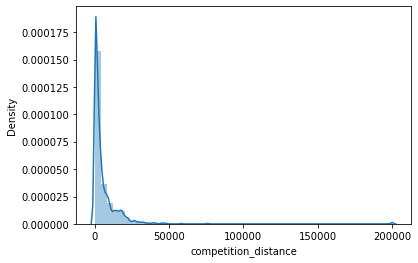

In [36]:
sns.distplot(df1['competition_distance'])

## 1.7.2. Categorical Attributes

In [37]:
#Conteo de valores únicos por cada attributo
cat_attributes.apply(lambda x:x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

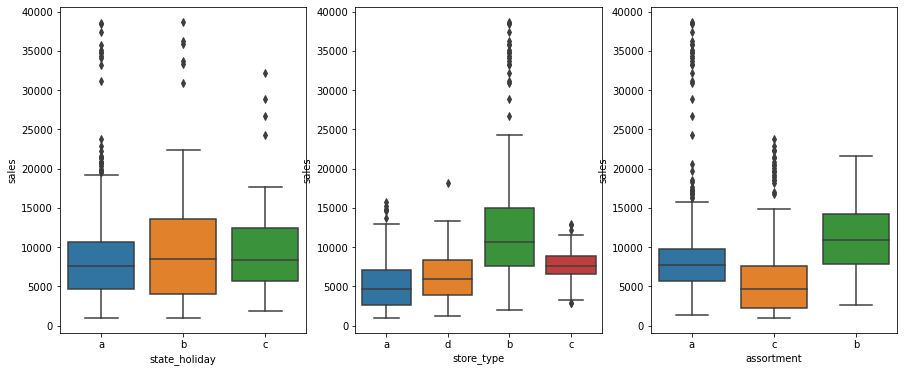

In [38]:
aux1=df1[(df1['state_holiday']!='0') & (df1['sales']>0)]
#a = feriado, b = Feriado de Páscoa, c = Natal

fig = plt.figure(figsize =(15, 6))

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0. FEATURE ENGINEERING

In [39]:
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

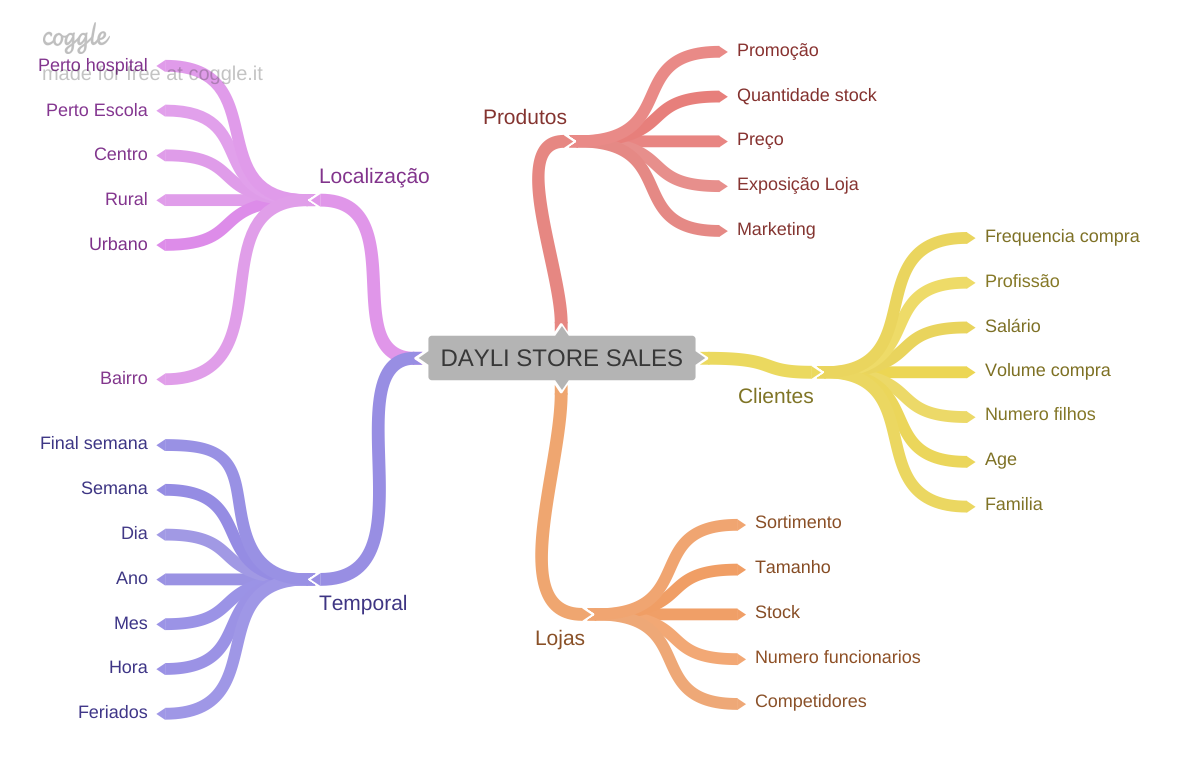

In [40]:
Image('img/DAYLI_STORE_SALES.png')

## 2.1.1. Hipoteses Lojas

**1.** Lojas com maior número de funcionários deveriam vender mais <br>
**2.** Lojas com maior capacidade de estoque deveriam vender mais <br>
**3.** Lojas com maior porte deveriam vender mais <br>
**4.** Lojas com maior sortimento deveriam vender mais <br>
**5.** Lojas com competidores mais perto deveriam vender menos <br>
**6.** Lojas com competidores a mais tempo deveriam vender mais

## 2.1.2. Hipóteses Produto

**1.** Lojas que investem mais em marketing deveriam vender mais <br>
**2.** Lojas com maior exposição de produtos deveriam vender mais <br>
**3.** Lojas com produtos com preço menor deveriam vender mais <br>
**4.** Lojas com promoções mais agressivas (descontos maiores) deveriam vender mais <br>
**5.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**6.** Lojas com mais dias de promoção deveriam vender mais <br>
**7.** Lojas com mais promoções consecutivas deveriam vender mais

## 2.1.3. Hipóteses Tempo

**1.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**2.** Lojas deveriam vender mais ao longo dos anos <br>
**3.** Lojas deverian vender mais no segundo semestre do ano <br>
**4.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**5.** Lojas deveriam vender menos nos finais de semana <br>
**6.** Lojas deveriam vender menos durante os feriados escolares

## 2.2. Lista Final de Hipóteses

**1.** Lojas com maior sortimento deveriam vender mais <br>
**2.** Lojas com competidores mais perto deveriam vender menos <br>
**3.** Lojas com competidores a mais tempo deveriam vender mais <br>
**4.** Lojas com promoções ativas por mais tempo deveriam vender mais <br>
**5.** Lojas com mais dias de promoção deveriam vender mais <br>
**6.** Lojas com mais promoções consecutivas deveriam vender mais<br>
**7.** Lojas abertas durante o periodo de natal deveriam vender menos <br>
**8.** Lojas deveriam vender mais ao longo dos anos <br>
**9.** Lojas deverian vender mais no segundo semestre do ano <br>
**10.** Lojas deveriam vender mais depois do dia 10 de cada mês <br>
**11.** Lojas deveriam vender menos nos finais de semana <br>
**12.** Lojas deveriam vender menos durante os feriados escolares

## 2.3. Feature Engineering

In [41]:
#Year
df2['year'] = df2['date'].dt.year

#Month
df2['month'] = df2['date'].dt.month

#Day
df2['day'] = df2['date'].dt.day

#week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')


#promo since
df2['promo_since']=df2['promo2_since_year'].astype(str) +'-'+ df2['promo2_since_week'].astype(str)

df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x+'-1','%Y-%W-%w') - datetime.timedelta(days=7))

df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x:x.days).astype(int)

#competition since
#df2['competition_since'] = df2.apply(lambda x: datetime.datetime( year = x['competition_open_since_year'], month=x['competition_open_since_month'], day=1))
#df2['competition_time_month'] = ((df2['date']-df2['competition_since'])/30).apply(lambda x:x.days).astype(int)

#assortments
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holidays
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

In [42]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0. FILTRAGEM DE VARIAVEIS

In [43]:
df3 = df2.copy()


In [44]:
# Para mostrar todas as colunas do dataset
pd.set_option('display.max_columns', None)
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-07-27,0


## 3.1. Filtragem de Linhas

In [45]:
df3 = df3[(df3['open']!=0) & (df3['sales']>0)]

## 3.2. Seleção de Colunas


In [46]:
cols_drop = ['customers', 'open','promo_interval','month_map']

In [47]:
df3 = df3.drop(cols_drop, axis=1)

In [48]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [49]:
df4 = df3.copy()

## 4.1. Analise Univariada

## 4.1.1. Variavel Resposta

<AxesSubplot:xlabel='sales', ylabel='Density'>

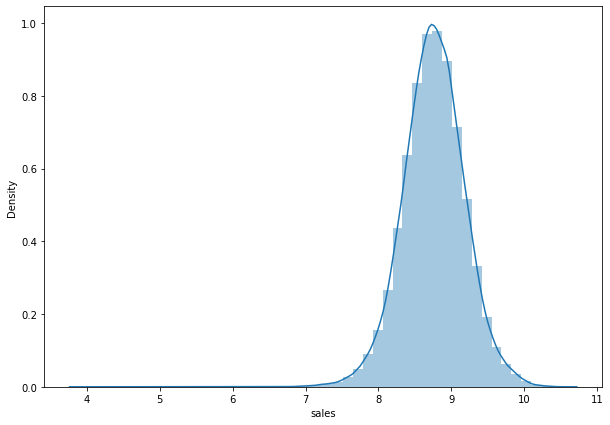

In [50]:
fig = plt.figure(figsize =(10, 7))
sns.distplot(np.log1p(df4['sales']))
# Aplicando transformação logaritmica
#Descobrir a distribuição dos dados, kurtosis. 

## 4.1.2. Variavel Numerica

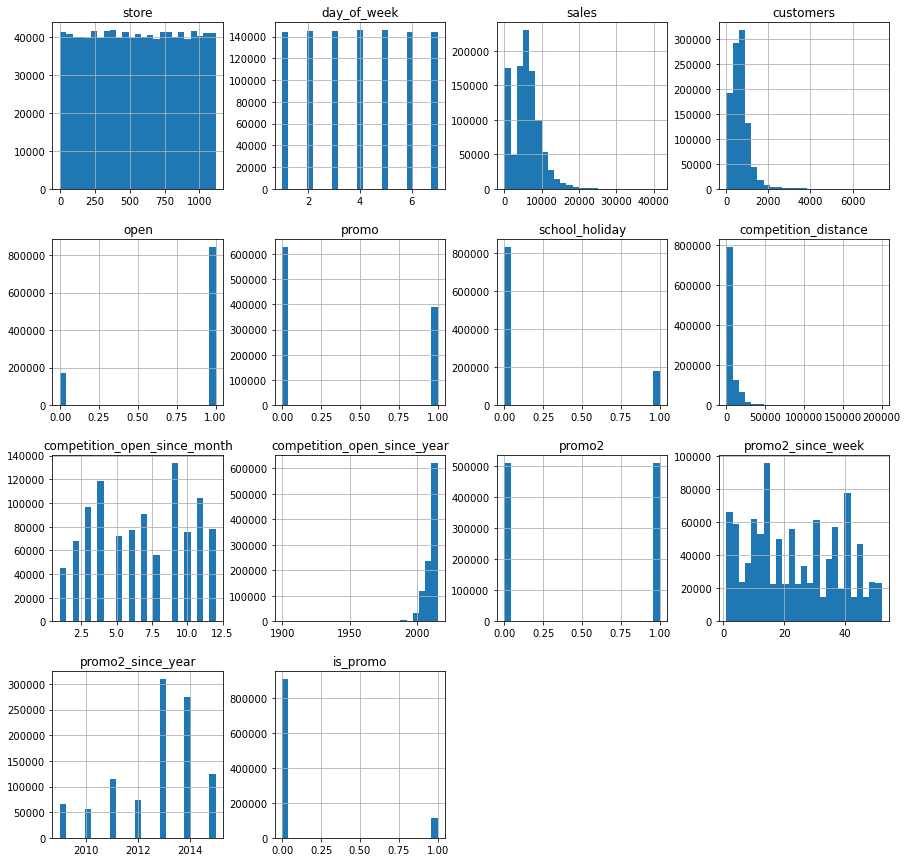

In [51]:
num_attributes.hist(figsize=(15, 15),bins = 25);

## 4.1.3. Variaveis Categóricas

In [52]:
df4['store_type'].drop_duplicates()

0     c
1     a
12    d
84    b
Name: store_type, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

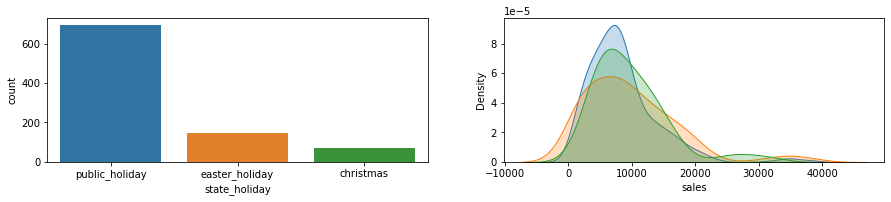

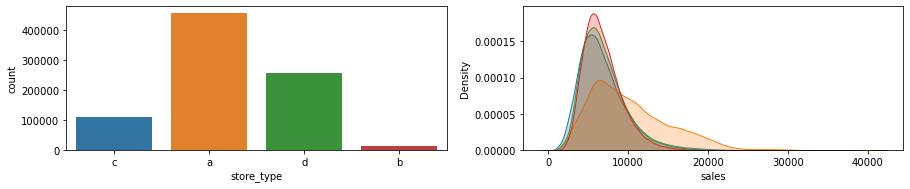

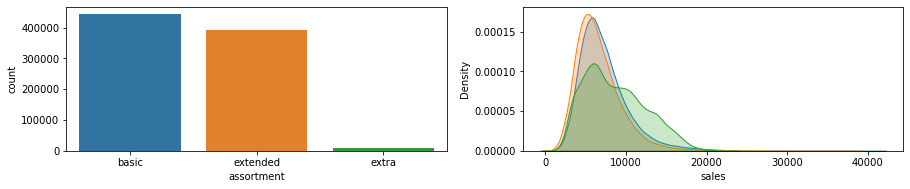

In [53]:
#State holiday
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,1)
a = df4[df4['state_holiday']!= 'regular_day']

sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] =='public_holiday']['sales'],label='public_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='easter_holiday']['sales'],label='easter_holiday',shade=True)
sns.kdeplot(df4[df4['state_holiday'] =='christmas']['sales'],label='christmas',shade=True)

#Store_type
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] =='a']['sales'],label='a',shade=True)
sns.kdeplot(df4[df4['store_type'] =='b']['sales'],label='b',shade=True)
sns.kdeplot(df4[df4['store_type'] =='c']['sales'],label='c',shade=True)
sns.kdeplot(df4[df4['store_type'] =='d']['sales'],label='d',shade=True)

#Assortment
fig = plt.figure(figsize =(15, 9))

plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] =='extended']['sales'],label='extended',shade=True)
sns.kdeplot(df4[df4['assortment'] =='basic']['sales'],label='basic',shade=True)
sns.kdeplot(df4[df4['assortment'] =='extra']['sales'],label='extra',shade=True)


## 4.2. Analise Bivariada

### H1. Lojas com maior sortimento deveriam vender mais
**FALSO** Lojas com maior sortimento vendem menos!

In [54]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()

<AxesSubplot:xlabel='year_week'>

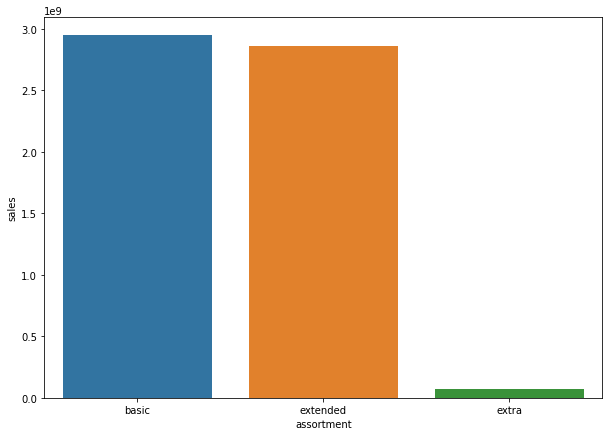

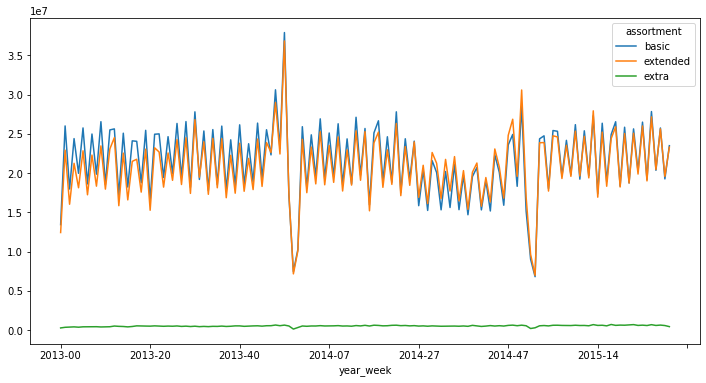

In [65]:
fig = plt.figure(figsize =(10, 7))
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
#fig = plt.figure(figsize =(10, 7))
aux2.pivot(index='year_week',columns='assortment',values='sales').plot(figsize =(12, 6))

### H2. Lojas com competidores mais próximos deveriam vender menos
**FALSO** Lojas com competidores mais próximos vendem mais

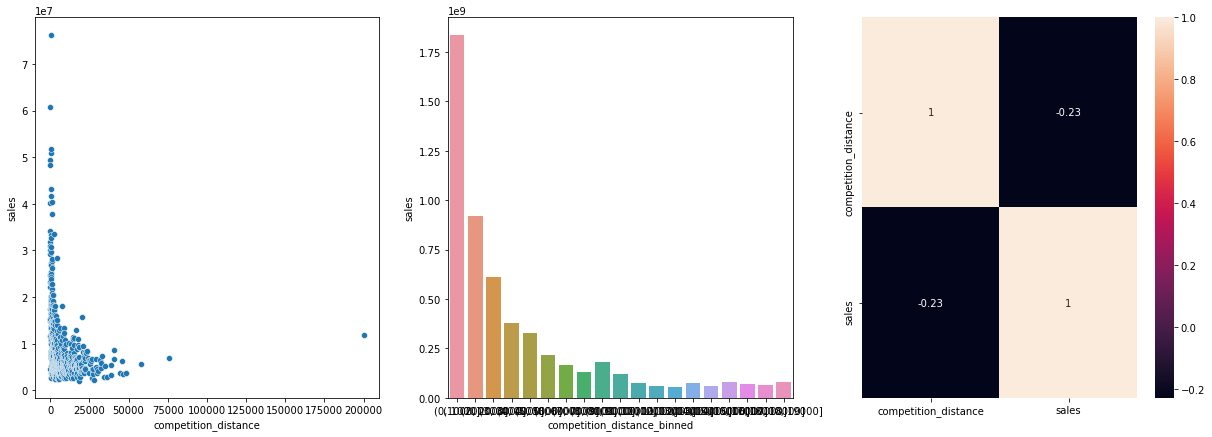

In [86]:
#Concentração de vendas está nas lojas que tem competidores mais próximos
fig = plt.figure(figsize =(21, 7))
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales',data=aux1);
data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABLwAAAG1CAYAAADz6O1VAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuNCwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8QVMy6AAAACXBIWXMAAAsTAAALEwEAmpwYAACMoklEQVR4nOzde5xcdXn48c8ze8lmN1c2VxKSEAiGhEvAKKiACl4CBUEEBK9VbKpVwVKt2lqt1ktbLS0IilFR8VdFFC9oEbWgAhWVgAEJt4QQICE3QpJNdjPZy3x/f8zZZRNyz+zOzO7nndd57Zz7c87MzmSe/X6fb6SUkCRJkiRJkgaKXLkDkCRJkiRJkkrJhJckSZIkSZIGFBNekiRJkiRJGlBMeEmSJEmSJGlAMeElSZIkSZKkAcWElyRJkiRJkgaUikt4RcS1EbE2Ih7Yi23/MyIWZdOjEbGxH0KUJA0Q+/iZMzUibo2I+yPiNxExuT9ilCRJkrTvIqVU7hi2ExGnAFuA61JKR+3Dfu8HjkspvbPPgpMkDSj78pkTEd8HfpZS+lZEnAq8I6X01v6IU5IkSdK+qbgWXiml24Fney+LiMMi4paIuCci7oiImTvZ9SLgu/0SpCRpQNjHz5xZwK3Z418DZ/djqJIkSZL2QcUlvHZhAfD+lNILgQ8CX+q9MiKmAocCt5UhNknSwLKrz5z7gDdkj18PDI+I5jLEJ0mSJGkPassdwJ5ExDDgpcD3I6J78ZAdNrsQ+EFKqas/Y5MkDSx7+Mz5IHBVRPwlcDuwEujs7xglSZIk7VnFJ7wotkLbmFKas5ttLgTe2z/hSJIGsF1+5qSUngbOhZ7E2BtSSpv6NzxJkiRJe6PiuzSmlFqAxyPifIAoOrZ7fUS8ABgN3FWmECVJA8TuPnMiYkxEdH9ufhS4tkxhSpIkSdqDikt4RcR3KSavXhARKyLiYuDNwMURcR+wmO0LBV8EXJ8qbbhJSVLF28fPnFcAj0TEo8B44DNlCFmSJEmqKhFxbUSsjYgHdrE+IuLKiFgaEfdHxPElOa95IkmSJEmSJPWFiDgF2AJcl1I6aifrzwDeD5wBnABckVI64UDPW3EtvCRJkiRJkjQwpJRuB57dzSZnU0yGpZTS74FRETHxQM9bUUXrx4wZk6ZNm1buMCRpwLnnnnueSSmNLXcclcTPHEnqO37uPF/HM8vsWqPdGnrwyeUOQVWgs31l7HmrPSvle1L92MP+Gpjfa9GClNKCfTjEJOCpXvMrsmWrDiSuikp4TZs2jYULF5Y7DEkacCLiiXLHUGn8zJGkvuPnjiQNHllya18SXDvaWRLvgBNyFZXwkiRJkiRJUh8rdJU7gt5WAIf0mp8MPH2gB7WGlyRJkiRJksrlJuBt2WiNJwKbUkoH1J0RbOElSZIkSZI0uKRCv50qIr4LvAIYExErgE8AdQAppWuAmymO0LgUaAPeUYrzmvCSJEmSJEkaTAr9l/BKKV20h/UJeG+pz2uXRkmSJEmSJA0otvCSJEmSJEkaRFI/dmksFxNekiRJkiRJg0k/dmksF7s0SpIkSZIkaUCxhZckSZIkSdJgYpdGSZIkSZIkDSiFrnJH0Ofs0ihJkiRJkqQBxRZekiRJkiRJg4ldGiVJkiRJkjSgDIJRGgdEwqtQSCxf38qaljzjRzQwrbmJXC7KHZYkSZIkSZLKoOoTXoVC4pbFq7nshkXkOwo01OW4/II5zJs9waSXJEmSJEnSDtIg6NJY9UXrl69v7Ul2AeQ7Clx2wyKWr28tc2SSJEmSJEkVqFAo3VShqr6F15qWfE+yq1u+o8DazXmmjx1WpqgkSdVi3Zf/337tN/Y9bylxJJIkSZJKpeoTXuNHNNBQl9su6dVQl2Pc8IYyRiVJkiRJklSh7NJY+aY1N3H5BXNoqCteSncNr2nNTWWOTJIkSZIkqQIVuko3Vaiqb+GVywXzZk9g5iUns3ZznnHDHaVRkiRJkiRpMKv6hBcUk17Txw6zZpckSZIkSdKeDIIujQMi4SVJkiRJkqS9VMGjK5ZK1dfwkiRJkiRJknqzhZckSZIkSdJgYpdGSZIkSZIkDSh2aZQkSZIkSZKqiy28JEmSJEmSBpGUusodQp8z4SVJkiRJkjSYDIIaXnZplCRJkiRJ0oBiCy9JkiRJkqTBZBAUrTfhJUmqCBFxLXAmsDaldNRO1n8IeHM2WwscCYxNKT0bEcuBzUAX0JlSmts/UUuSJElVyC6NkiT1m28C83a1MqX0+ZTSnJTSHOCjwG9TSs/22uSV2XqTXZIkSdIgZwsvSVJFSCndHhHT9nLzi4Dv9mE4kiRJ0sBVGPijNNrCS5JUVSKikWJLsBt7LU7ALyPinoiYv5t950fEwohYuG7dur4OVZIkSapMqVC6qUKZ8JIkVZuzgP/boTvjy1JKxwOnA++NiFN2tmNKaUFKaW5Kae7YsWP7I1ZJkiRJZWCXRklStbmQHbozppSezn6ujYgfAS8Gbi9DbJIkSVLlGwSjNNrCS5JUNSJiJPBy4Ce9ljVFxPDux8BrgAfKE6EkSZJUBQZBl0ZbeEmSKkJEfBd4BTAmIlYAnwDqAFJK12SbvR74ZUqptdeu44EfRQQUP9e+k1K6pb/iliRJklR5THhJkipCSumivdjmm8A3d1i2DDi2b6KSJEmSBqBB0KXRhJckSZIkSdJgYsJLkiRJkiRJA0lKXeUOoc9ZtF6SJEmSJEkDSp8lvCLiBRGxqNfUEhEf6KvzSZIkSZIkaS8UCqWbKlSfdWlMKT0CzAGIiBpgJfCjvjqfJEmSJEmS9kKq3ERVqfRXl8bTgMdSSk/00/kkSZIkSZI0SPVX0foLge/ubEVEzAfmA0yZMqWfwpEkSZIkSRqkKrgrYqn0eQuviKgHXgd8f2frU0oLUkpzU0pzx44d29fhSJIkSZIkDW6pULqpQvVHl8bTgXtTSmv64VySJEmSJEka5PqjS+NF7KI7oyRJkiRJkvrZIOjS2KcJr4hoBF4N/HVfnkeSJEmSJEl7qYK7IpZKnya8UkptQHNfnkOSJEmSJEnqrb9GaZQkSZIkSVIlsEujJEmSJEmSBpRBkPDqj1EaJUmSJEmSpH5jCy9JkiRJkqTBxKL1kiRJkiRJGlDs0ihJkiRJkiRVFxNekiRJkiRJg0kqlG7ag4iYFxGPRMTSiPjITtaPjIifRsR9EbE4It5Riku0S6MkSZIkSdJg0k9dGiOiBrgaeDWwArg7Im5KKT3Ya7P3Ag+mlM6KiLHAIxHx3yml9gM5ty28JEmSJEmS1BdeDCxNKS3LEljXA2fvsE0ChkdEAMOAZ4HOAz2xLbwkSZIkSZIGkxKO0hgR84H5vRYtSCktyB5PAp7qtW4FcMIOh7gKuAl4GhgOvDGlAw/QhJckSZIkSdJgUsIujVlya8EuVsfOdtlh/rXAIuBU4DDgVxFxR0qp5UDiskujJEmSJEmS+sIK4JBe85MptuTq7R3AD1PRUuBxYOaBntiElyRJkiRJ0mBSKJRu2r27gRkRcWhE1AMXUuy+2NuTwGkAETEeeAGw7EAv0S6NkiRJkiRJg0nasVdhX50mdUbE+4BfADXAtSmlxRHx7mz9NcC/AN+MiD9T7AL54ZTSMwd6bhNekiRJkiRJ6hMppZuBm3dYdk2vx08Dryn1eU14SZIkSZIkDSYlLFpfqUx4SZIkSZIkDSaDIOFl0XpJkiRJkiQNKLbwkiRJkiRJGkzSwG/hZcJLkiRJkiRpMLFLoyRJkiRJklRdbOElSZIkSZI0mKRU7gj6nAkvSZIkSZKkwcQujZIkSZIkSVJ1sYWXJEmSJEnSYDIIWniZ8JIkSZIkSRpM0sBPeNmlUZIkSZIkSQOKLbwkSZIkSZIGkVQY+KM02sJLklQRIuLaiFgbEQ/sYv0rImJTRCzKpo/3WjcvIh6JiKUR8ZH+i1qSJEmqQoVC6aYKZcJLklQpvgnM28M2d6SU5mTTpwAioga4GjgdmAVcFBGz+jRSSZIkSRXNLo2SpIqQUro9Iqbtx64vBpamlJYBRMT1wNnAgyUMT5IkSRo4LFovSVJFeUlE3BcRP4+I2dmyScBTvbZZkS17noiYHxELI2LhunXr+jpWSZIkqTIVUummCmXCS5JULe4FpqaUjgW+CPw4Wx472Xann7wppQUppbkppbljx47tmyglSZIklZ0JL0lSVUgptaSUtmSPbwbqImIMxRZdh/TadDLwdBlClCRJkqrDIChaX/U1vAqFxPL1raxpyTN+RAPTmpvI5Xb2x35JUjWLiAnAmpRSiogXU/yjzXpgIzAjIg4FVgIXAm8qW6CSJElSpavgRFWpVHXCq1BI3LJ4NZfdsIh8R4GGuhyXXzCHebMnmPSSpCoTEd8FXgGMiYgVwCeAOoCU0jXAecB7IqIT2ApcmFJKQGdEvA/4BVADXJtSWlyGS5AkSZJUIao64bV8fWtPsgsg31HgshsWMfOSk5k+dliZo5Mk7YuU0kV7WH8VcNUu1t0M3NwXcUmSJEkDTqrcYvOl0qc1vCJiVET8ICIejoiHIuIlpTz+mpZ8T7KrW76jwNrN+VKeRpIkSZIkaeAYBDW8+rpo/RXALSmlmcCxwEOlPPj4EQ001G1/CQ11OcYNbyjlaSRJkiRJJfKxz17OKX9xIee85d3lDkVl9p+Xf4qHH7yTe+/5FcfNOWqn21z3rS+y+IHbWfSnW/nqgv+gtrbYUe2ss17Dvff8ioV3/5Lf33UzL3vpi/ozdFWBPkt4RcQI4BTg6wAppfaU0sZSnmNacxOXXzCnJ+nVXcNrWnNTKU8jSZIkSSqRc854Nddc/ulyh6EyO33eqcw4/FBmzjqJ97znw1x91ed2ut13v/sjZh91CnOOO42hQxu4+J3FsYluu+1Ojn/hq5n7otfwV/P/jq985Qv9GX71K6TSTRWqL2t4TQfWAd+IiGOBe4BLU0qtpTpBLhfMmz2BmZeczNrNecYNd5RGSZIkSapkc+cczcpVa8odhsrsrLNey7f/+wcA/OGP9zJy1EgmTBjH6tVrt9vu57fc1vP47rsXMXnyRABaW9t6ljc1NpIGQU2qkkqV2xWxVPqyS2MtcDzw5ZTScUAr8JEdN4qI+RGxMCIWrlu3bp9PkssF08cO48TpY5g+dpjJLkmSJEl9IiKmRsSrssdDI2J4uWOSqtWkgyew4qmne+ZXrljFpIMn7HL72tpa3vzmN/CLX/y6Z9nZZ8/jgT//lpt+8i3+6q/+rk/jVfXpy4TXCmBFSukP2fwPKCbAtpNSWpBSmptSmjt27Ng+DEeSJEmS9k9E/BXF7zRfyRZNBn5ctoCkKhfx/MYqu2ulddUXP8sdd/yBO//vjz3LfvKTWzjq6JfzhvMu5pP//KE+iXPAGgRdGvss4ZVSWg08FREvyBadBjzYV+eTJEmSpD70XuBlQAtASmkJMG53O/TuzfK1677bDyFKle097347C+/+JQvv/iVPr1rN5EMO7lk3afJEnt5FV9d/+tjfMnZsMx/80D/vdP0dd/6B6dOn0tw8ui/CHpBSoVCyqVL1ZQ0vgPcD/x0R9cAy4B19fD5JkiRJ6gvbUkrt3a1SIqIW2G3ThpTSAmABQMczyyq3GYTUT758zbf48jXfAuCM00/jb97zl3zvez/hhBcfT8umlufV7wJ45zsu4jWvfgWvfu0bt2sBdthh03jsseUAHDfnKOrr61i/fkO/XMeAUMEts0qlTxNeKaVFwNy+PIckSZIk9YPfRsQ/AEMj4tXA3wA/LXNMVelDn/hX7v7T/Wzc2MJp57yFv7n4rbzhrNeWOyz1s5t/fivz5p3KIw/9H21bt/Kud13Ws+6nP7mO+e/+EKtWreFLV/8rTzyxgjvvuAmAH//4Zj79mf/i3NefwVvech4dHZ3kt+Z505vfU65LUYXq6xZekiRJkjQQfAS4GPgz8NfAzcDXyhpRlfr8J583lpkGqUsu/cedLj/r7Lf1PG5onLrTbT7/hS/x+S98qU/iGhQGwSiNJrwkSZIkac+GAtemlL4KEBE12bK2skYlSftjEHRp7MtRGiVJkiRpoLiVYoKr21Dgf8sUiyRpD2zhJUmSJEl71pBS2tI9k1LaEhGN5QxIkvZbBY+uWComvCRJkiRpz1oj4viU0r0AEfFCYGuZY5Kk/TMIujSa8JIkSZKkPfsA8P2IeDqbnwi8sXzhSJJ2x4SXJEmSJO1BSunuiJgJvAAI4OGUUkeZw5Kk/eMojZIkSZKkzIuAaRS/Rx0XEaSUritvSJK0H+zSKEmSJEmKiG8DhwGLgK5scQJMeElSBTLhJUmSJEl7NheYlVIa+M0iJA14yVEaJUmSJEnAA8AEYFW5A5GkA2aXRkmSJEkSMAZ4MCL+CGzrXphSel35QpIk7YoJL0mSJEnas38udwCSVDK28JIkSZIkpZR+W+4YJKlk0sCv4ZUrdwCSJEmSVOki4sSIuDsitkREe0R0RURLueOSJO2cLbwkSZIkac+uAi4Evk9xxMa3ATPKGpEk7S+7NEqSJEmSAFJKSyOiJqXUBXwjIn5X7pgkaX8kE16SJEmSJKAtIuqBRRHx78AqoKnMMUmSdsEaXpIkSZK0Z2+l+P3pfUArcAhwblkjkqT9VUilmyqUCS9JkiRJ2rNzUkr5lFJLSumTKaXLgDPLHZQk7ZdCoXRThTLhJUmSJEl79vadLPvL/g5CkrR3rOElSZIkSbsQERcBbwIOjYibeq0aAawvT1SSdIAquCtiqZjwkiRJkqRd+x3FAvVjgP/otXwzcH9ZIpKkA9WPCa+ImAdcAdQAX0sp/etOtnkF8F9AHfBMSunlB3peE16SJEmStAsppSeAJyLiVcDWlFIhIo4AZgJ/Lm90klTZIqIGuBp4NbACuDsibkopPdhrm1HAl4B5KaUnI2JcKc5tDS9JkiRJ2rPbgYaImATcCrwD+GZZI5Kk/ZRSKtm0By8GlqaUlqWU2oHrgbN32OZNwA9TSk9msa0txTWa8JIkSZKkPYuUUhtwLvDFlNLrgVlljkmS9k8hlWyKiPkRsbDXNL/XmSYBT/WaX5Et6+0IYHRE/CYi7omIt5XiEu3SKEmSJEl7FhHxEuDNwMXZMr9PSRr0UkoLgAW7WB0722WH+VrghcBpwFDgroj4fUrp0QOJyzdoSZIkSdqzDwAfBX6UUlocEdOBX5c3JEnaT/1XtH4FcEiv+cnA0zvZ5pmUUivQGhG3A8cCJrwkSZIkqS+llH4L/LbX/DLgkvJFJEn7L/VfwutuYEZEHAqsBC6kWLOrt58AV0VELVAPnAD854Ge2ISXJEmSJO1CRPxXSukDEfFTnt8Nh5TS68oQliRVhZRSZ0S8D/gFUANcm7WSfXe2/pqU0kMRcQtwP1AAvpZSeuBAzz0gEl6FQmL5+lbWtOQZP6KBac1N5HI76yYqSZIkSfvk29nPL5Q1Ckkqpf5r4UVK6Wbg5h2WXbPD/OeBz5fyvFWf8CoUErcsXs1lNywi31GgoS7H5RfMYd7sCSa9JEmSJB2QlNI92c/f7mlbSaoahXIH0PeqPuG1fH1rT7ILIN9R4LIbFjHzkpOZPnZYmaOTJO2tiLgWOBNYm1I6aifr3wx8OJvdArwnpXRftm45sBnoAjpTSnP7JWhJ0oAXEX9mJ10Zu6WUjunHcCRJe6nqE15rWvI9ya5u+Y4CazfnTXhJUnX5JnAVcN0u1j8OvDyltCEiTqc49PEJvda/MqX0TN+GKEkahM7Mfr43+9ndxfHNQFv/hyNJB64fi9aXTdUnvMaPaKChLrdd0quhLse44Q1ljEqStK9SSrdHxLTdrP9dr9nfUxzSWJKkPpVSegIgIl6WUnpZr1UfiYj/Az5Vnsgk6QAMgoRXrtwBHKgpoxv59DlH0VBXvJSGuhyfPucopoxuLHNkkqQ+dDHw817zCfhlRNwTEfN3tVNEzI+IhRGxcN26dX0epCRpQGmKiJO6ZyLipUBTGeORJO1G1bfwenJDG1+8bQkXnzSdCEgJvnjbEo6fMtoujZI0AEXEKykmvE7qtfhlKaWnI2Ic8KuIeDildPuO+6aUFlDsCsncuXMH/p+1JEmldDFwbUSMpPiHlk3AO8sbkiTtJ4vWV741LXmeWL+Vq3+9dLvl1vCSpIEnIo4BvgacnlJa3708pfR09nNtRPwIeDHwvISXJEn7Kxut8diIGAFESmlT7/UR8faU0rfKE50k7ZvBUMOrT7s0RsTyiPhzRCyKiIV9cY7uGl69WcNLkgaeiJgC/BB4a0rp0V7LmyJiePdj4DXAA+WJUpI00KWUWnZMdmUu7fdgJEm71B8tvPp01KxpzU1cfsEcLrthEfmOAg11OS6/YA7Tmu1OL0nVJCK+C7wCGBMRK4BPAHUAKaVrgI8DzcCXIgKgM6U0FxgP/ChbVgt8J6V0S79fgCRpsItyByBJe80ujZUvlwvmzZ7AzEtOZu3mPOOGNzCtuYlczs8bSaomKaWL9rD+XcC7drJ8GXBsX8UlSdJeGvj9gyQNGHZpPHB7HDXrQEfMKhQSy9e3sqbFZJckSZKksvFLiCRVkL5u4bXHUbMOZMSsQiFxy+LVz+vOOG/2BJNekiRJkvrT/5U7AEnaa3ZpPDB9PWrW8vWtPckugHxHgctuWMTMS052hEZJkiRJJRMRQ4A3ANPo9T0qpfSp7Of7yhOZJO27NAgSXn3WpbE/Rs1a05LvSXZ1y3cUWLs5X8rTSJIkSdJPgLOBTqC11yRJqkB92cKrz0fNGj+igYa63HZJr4a6HOOGN5TyNJIkSZI0OaU0r9xBSFJJDIIWXn2W8OqPUbOmNTdx1ZuO4/4VmygkqAk4evJIpjU39eVpJUmSJA0+v4uIo1NKfy53IJJ0oAZDl8a+Llrf59o7EwtuX7Zd0XpJkiRJKrGTgL+MiMeBbRRHZUwppWPKG5YkaWeqOuFl0XpJkiRJ/eT0cgcgSSUzCFp49VnR+v5g0XpJkiRJ/SGl9AQwCjgrm0ZlyySp6qRC6aZKVdUJr+6i9b1ZtF6SJElSqUXEpcB/A+Oy6f9FxPvLG5UkaVeqOuE1rbmJyy+Y05P06q7hZdF6SZIkSSV2MXBCSunjKaWPAycCf1XmmCRpvwyGFl5VXcMrlwvmzZ7AzEtOZu3mPOOGNzCtuYlcLsodmiRJkqSBJYCuXvNd2TJJqjqVnKgqlapOeEEx6TV97DCL1EuSJEnqS98A/hARP8rmzwG+Xr5wJOkApIGfr6/6hJckSZIk9bWU0uUR8RvgJIotu96RUvpTeaOSJO2KCS9JkiRJ2oWIGJFSaomIg4Dl2dS97qCU0rPlik2S9pddGiVJkiRpcPsOcCZwD5B6LY9sfno5gpKkA5EKdmmUJEmSpEErpXRm9vPQcsciSdp7uXIHIEmSJEmVLiJu3ZtlklQNUqF0U6WyhZckSZIk7UJENACNwJiIGE2xKyPACODgsgUmSQcgOUqjJEmSJA1qfw18gGJy695ey1uAq8sRkCRpz0x4SZIkSdIupJSuAK6IiPenlL5Y7ngkqRQquStiqZjwkiRJkqRdiIhTU0q3ASsj4twd16eUfliGsCTpgDhKoyRJkiQNbi8HbgPO2sm6BJjwkqQKZMJLkiRJknYhpfSJ7OGnUkqP914XEYeWISRJOmAplTuCvpcrdwCSJEmSVAVu3MmyH/R7FJJUAqkQJZsqlS28JEmSJGkXImImMBsYuUMNrxFAQ3mikiTtiQkvSZIkSdq1FwBnAqPYvo7XZuCvyhGQJB2oSm6ZVSomvCRJkiRpF1JKPwF+EhEvSSndVe54JKkUrOElSZIkSQJYHxG3RsQDABFxTER8rNxBSZJ2bkAkvAqFxLJ1W7jrsWdYtm4LhcIgSFVKkiRJ6k9fBT4KdACklO4HLixrRJK0nyxaXwUKhcQti1dz2Q2LyHcUaKjLcfkFc5g3ewK5XOXeeEmSJElVpTGl9MeI7b5jdJYrGEk6ECkN/HxJ1bfwWr6+tSfZBZDvKHDZDYtYvr61zJFJkiRJGkCeiYjDgAQQEecBq8obkiRpV6q+hdealnxPsqtbvqPA2s15po8dVqaoJEmSJA0w7wUWADMjYiXwOPDm8oYkSfsnFfa8TbWr+oTX+BENNNTltkt6NdTlGDe8oYxRSZIkSRpIUkrLgFdFRBOQSyltLndMkrS/CnZprHzTmpu4/II5NNQVL6W7hte05qYyRyZJkiRpoIiI5oi4ErgD+E1EXBERzeWOS5K0c1XfwiuXC+bNnsDMS05m7eY844Y3MK25yYL1kiRJkkrpeuB24A3Z/JuB7wGvKltEkrSfBkPR+qpPePWWUrkjkCRJkjRAHZRS+pde85+OiHPKFYwkHYhUMOFV8QqFxC2LV/eM1NjdpXHe7Am28pIkSZJUKr+OiAuBG7L584D/KWM8kqTdqPoaXsvXt/Yku6A4QuNlNyxi+frWMkcmSZIkaQD5a+A7QHs2XQ9cFhGbI6KlrJFJ0j5KqXRTpar6Fl5rWvLbjdAIxaTX2s15po8dVqaoJEmSJA0kKaXh5Y5BkkplMHRp3OcWXhGRi4gRfRHM/hg/oqFnhMZuDXU5xg1vKFNEkqRu+/KZERHXRsTaiHhgF+sjIq6MiKURcX9EHN9r3byIeCRb95FSxS9JUm8RcUxEvC4izu2eyh2TJGnn9irhFRHfiYgREdEEPAg8EhEf6tvQ9s605iYuv2BOT9Kru4bXtOamMkcmSYPTAXxmfBOYt5v1pwMzsmk+8OXsfDXA1dn6WcBFETFr/69AkqTni4hrgWspjtJ4VjadWdagJGk/FVKUbKpUe9ulcVZKqSUi3gzcDHwYuAf4fJ9FtpdyuWDe7AnMuvRk1rRso7W9k6kHmeySpDLar8+MlNLtETFtN5ucDVyXUkrA7yNiVERMBKYBS1NKywAi4vps2wcP+EokSXrOiSkl/6AiaUBIFZyoKpW97dJYFxF1wDnAT1JKHUBFlCYrFBJPPtvKvU9u5O3f+CPv/OZC/uKLd3DL4tUUChURoiQNNn31mTEJeKrX/Ips2a6WP09EzI+IhRGxcN26dSUISZI0iNxlC2JJ2nd7W34kIl4UEV0RcV4pzru3Ca+vAMuBJuD2iJgK7NVIJBFRExF/ioif7V+Iu1YoJG5ZvJof/mkl//CjPztSoyRVhv3+zNiDnf0ZKu1m+fMXprQgpTQ3pTR37NixJQhJkjSIfIti0uuRrJbknyPi/nIHJUn7o79Gadzb8iPZdv8G/KJU17hXXRpTSlcCV/Za9EREvHIvz3Ep8BBQ8kL3y9e3ctkNi3jXydMdqVGSKsQBfmbszgrgkF7zk4GngfpdLJckqZSuBd4K/Bko7GFbSapo/Vh768XsXfmR9wM3Ai8q1Yn3tmj9+Ij4ekT8PJufBbx9L/abDPwF8LUDinIX1rTkexJdjtQoSZVhfz8z9sJNwNuy0RpPBDallFYBdwMzIuLQiKgHLsy2lSSplJ5MKd2UUno8pfRE91TuoCSp3HqXDcmm+b1W77H8SERMAl4PXFPKuPa2S+M3KTYrOzibfxT4wF7s91/A37Obv4AcSD2V8SMaaKjLceM9K7jk1BmO1ChJleGb7MdnRkR8F7gLeEFErIiIiyPi3RHx7myTm4FlwFLgq8DfAKSUOoH3Zed8CLghpbS4ZFcjSVLRw9lIxBdFxLndU7mDkqT9kVKUcHqubEg2Leh1qr0pP/JfwIdTSl2lvMa9HaVxTErphoj4KBS/XETEbgOJiDOBtSmleyLiFbvaLrsRCwDmzp27T0WNpzU3cfkFc7jshkV8+/dPMP+U6RwxfjhHThjBoWOayOUG/qgDklSB9vkzI9vuoj2sT8B7d7HuZooJMUmS+spQYBvwml7LEvDD8oQjSftvT7W3SmhXZUl6mwtcHxEAY4AzIqIzpfTjAznx3ia8WiOimSwL192VZA/7vAx4XUScATQAIyLi/6WU3rLf0e4glwvmzZ7AzEtOZu3mPOOGNzCt2USXJJXZ/nxmSJJU0VJK7yh3DJJUhXrKjwArKZYfeVPvDVJKh3Y/johvAj870GQX7H3C6zKK9VAOi4j/A8YCux0mMqX0UeCjAFkLrw+WMtnVLZcLpo8dZnF6Saoc+/yZIUlSpcvqE3+R4h/2E3AncGlKacXe7D/04JP7MDoNBFufvqPcIWgQ6a+i9Vlvj+7yIzXAtSmlxd1lS1JKJa3b1dvejtJ4b0S8HHgBxf6Xj6SUOvoqKElS9fIzQ5I0QH0D+A5wfjb/lmzZq8sWkSTtp9R/ozTutPzIrhJdKaW/LNV5d5vw2k0RxiMigpTSXvVXTyn9BvjNvoUmSaompfrMkCSpQo1NKX2j1/w3I+ID5QpGkrR7e2rhddZu1lmgUZLUm58ZkqSB7JmIeAvw3Wz+ImB9GeORpP3WX10ay2m3Ca9qKsxYKCSWr29lTUue8SMsXi9J/a2aPjMkSdoP7wSuAv6T4h9yfgf42SepKvXfII3ls7dF64mIvwBmUxxxEYCU0qf6Iqh9VSgkblm8mstuWES+o0BDXY7LL5jDvNkTTHpJUhlU8meGJEn76V+At6eUNgBExEHAFygmwiRJFSa3NxtFxDXAG4H3UyxAfD4wtQ/j2ifL17f2JLsA8h0FLrthEcvXt5Y5MkkafCr9M0OSpP10THeyCyCl9CxwXBnjkaT9VkhRsqlS7VXCC3hpSultwIaU0ieBlwCH9F1Y+2ZNS74n2dUt31Fg7eZ8mSKSpEGtoj8zJEnaT7mIGN09k7Xw2useM5JUSVKKkk2Vam/foLszR20RcTDwLHBo34S078aPaKChLrdd0quhLse44Q272UuS1Ecq+jNDkqT99B/A7yLiBxTL31wAfKa8IUmSdmVvE14/jYhRwOeBeym+wX+1r4LaV9Oam7j8gjnPq+E1rbmp3KFJ0mBU0Z8ZfWX1lz+53/tOeM8nShiJJKkvpJSui4iFwKkUu+yfm1J6sMxhSdJ+Kex5k6q3twmvh4GulNKNETELOB74cZ9FtY9yuWDe7AnMvORk1m7OM264ozRKUhlV9GeGJEn7K0twmeSSVPUSAz9fsrc1vP4ppbQ5Ik4CXg18E/hyn0W1H3K5YPrYYZw4fQzTxw4z2SVJ5VPxnxmSJEmSBra9TXh1ZT//ArgmpfQToL5vQpIkVTk/MyRJkqQKVkilmyrV3ia8VkbEVygWZrw5Iobsw76SpMHFzwxJkiSpghWIkk2Vam+/gFwA/AKYl1LaCBwEfKivgpIkVTU/MyRJkiSV1V4VrU8ptQE/7DW/CljVV0FJkqqXnxmSJElSZRsMRev3dpRGSZIkSZIkDQCFcgfQD0x4SZIkSZIkDSKDoYWXRYQlSZIkSZI0oNjCS5IkSZIkaRCxS6MkSZIkSZIGFBNeVaBQSCxf38qaljzjRzQwrbmJXG7g90WVJEmSJEnSzlV1wqtQSNyyeDWX3bCIfEeBhrocl18wh3mzJ5j0kiRJkiRJ2gmL1le45etbe5JdAPmOApfdsIjl61vLHJkkSZIkSVJlKkTppkpV1S281rTke5Jd3UY31rNu8za7OEqSJEmSJA1SVZ3wGj+igYa6HKMb6zn3+MkMb6hhREMdb//GH+3iKEmSJEmStBMFuzRWtmnNTVz1puN420um8vU7l7E538WnfvagXRwlSZIkSZJ2IZVwqlRVnfDK5YJDm4dxxa1LyHcUiOB5XRzzHQXWbs6XKUJJkiRJkiT1t6ru0giwdnO+p0vjC8YPp6Eut13Sq6Eux7jhDWWMUJIkSZIkqXIU9rxJ1av6hNfEkQ287SVTueLWJYxurOfS02b0tPjqruE1rbmp3GFKkiRJkiRVhEIM/BpeVZ/w6irQk+BatSnPdXc9wfxTpnPcIaOY2tzkKI2SJEmSJEmDTFXX8IJil8beXRhXbcpz5a1LGVpfw/Sxw0x2SZIkSZIk9TIYitZXfQuvccMbrNslSZIkSZK0lwZDDa+qbuFVKCQeX7+FS0+bQUNd8VKs2yVJkiRJkjS4VXULr+XrW3nfd/7E6MZ6Lj5pOhGQC5g1cbhdGSVJkiRJknaiMAhSJlWd8FrTku8pVn/1r5f2LH/pYc1MGzOsjJFJkiRJkiRVpgIDP+NV1Qmv8SMamNo8lDOPmUT3iJo/vW+l9bskSZIkSZIGsaqu4TVldCPvP3UGP7t/JSkVuzP+81mzmTxyaLlDkyRJkiRJqkiO0ljhntzQxhdvW8Ib507hytuWkO8o0FCX49/ecAxnHXOwdbwkSZIkSZJ2MBhqeFV1C681LXnOPGZST7ILIN9R4MM33s/y9a1ljk6StC8iYl5EPBIRSyPiIztZ/6GIWJRND0REV0QclK1bHhF/ztYt7P/oJUmSJFWSPkt4RURDRPwxIu6LiMUR8clSn2P8iAZqcvQku7rlOwqs3Zwv9ekkSX0kImqAq4HTgVnARRExq/c2KaXPp5TmpJTmAB8FfptSerbXJq/M1s/tr7glSZKkalQo4VSp+rKF1zbg1JTSscAcYF5EnFjKE0wZ3chxh4yioW77y2ioy1m4XpKqy4uBpSmlZSmlduB64OzdbH8R8N1+iUySJEkaYAZDDa8+S3iloi3ZbF02lfRePLmhjat/vYRPnDW7J+nVUJfj399wDNOam0p5KklS35oEPNVrfkW27HkiohGYB9zYa3ECfhkR90TE/D6LUpIkSVJV6NOi9VkXlXuAw4GrU0p/2Mk284H5AFOmTNmn469pybNy4zbaO7qYf8p0CtlIjTUWq5ekarOzN+5d/ZHkLOD/dujO+LKU0tMRMQ74VUQ8nFK6/XknOYDPHEmSJGmgGAxF6/s04ZVS6gLmRMQo4EcRcVRK6YEdtlkALACYO3fuPrUAGz+igfPnTuZztzy8XR2vhrocR04cwfSxww74GiRJ/WIFcEiv+cnA07vY9kJ26M6YUno6+7k2In5EsYvk8xJeB/KZI0mSJA0UlVx7q1T6ZZTGlNJG4DcUu6CUzJTRjRw2dphF6yWp+t0NzIiIQyOinmJS66YdN4qIkcDLgZ/0WtYUEcO7HwOvAR7YcV9JkiRJg0eftfCKiLFAR0ppY0QMBV4F/Fspz/HkhjZWbdxKQ13ueS28LFovSdUjpdQZEe8DfgHUANemlBZHxLuz9ddkm74e+GVKqbXX7uMptiKG4ufad1JKt/Rf9JIkSVJ1GQwtvPqyS+NE4FtZHa8ccENK6WelPMGaljzfuusJLjl1BlfetoR8R4GGuhyfff3RFq2XpCqTUroZuHmHZdfsMP9N4Js7LFsGHNvH4UmSJEkDRrKG1/5LKd0PHNdXx4diDa8Nbe18+/dPcPFJ04koFq0/fsoocrmgUEgsX9/KmpY840c0MK25iZwF7SVJkiRJkga0fqnh1VemNTdx+QVz2NDWzg/vXUEu4Ihxw+kqQGdngVsWr+aMK+/goq/+gTOuvINbFq+mULBGsSRJkiRJGrwKJZwqVZ+O0tjXcrlg3uwJzLr0ZO59ciP/8KM/93RrXPDWuVx2w6Ke2l75jgKX3bCImZec7OiNkiRJkiRp0KrkRFWpVHULLygmvQqJnmQXFJNbC5941tEbJUmSJEmSBqGqbuHVbU1L/nnJrULC0RslSZIkSZJ2MBiKPVV9Cy+AxvpaGuq2v5Sf3reSz73+6J7lDXU5Lr9gjqM3SpIkSZKkQa0QpZsqVdW38CoUEmta8lxy6gyuvG1JTw2vN86dwqFjGrn5kpNZuznPuOGO0ihJkiRJkjQYVH3Ca/n6VlZubON7C5/k4pOmEwEpwfcWPsm8oyYwfewwi9RLkiRJkiRl+rNofUTMA64AaoCvpZT+dYf1bwY+nM1uAd6TUrrvQM9b9QmvTVvbGTW0ngtfNIUrbn2uhdfnXn+03RclSZIkSZJ20F8Jr4ioAa4GXg2sAO6OiJtSSg/22uxx4OUppQ0RcTqwADjhQM9d9QmvrgJ89Ed/ZnRjfU8Lr1zAoWPsvihJkiRJklRGLwaWppSWAUTE9cDZQE/CK6X0u17b/x6YXIoTV33R+me2bNvpCI3Ptm0rU0SSJEmSJEmVK5Vwioj5EbGw1zS/16kmAU/1ml+RLduVi4GfH/AFMgBaeE0cOZSpzUN549wp2xWt/9zrj6ZQSLbykiRJkiRJ6qWUoyumlBZQ7Ia4Mzs7U9rphhGvpJjwOqkUcVV9C6/ZE0fwz2fN7kl2AeQ7Cnz0R39m+frWMkcnSZIkSZI0aK0ADuk1Pxl4eseNIuIY4GvA2Sml9aU4cdUnvGprcwyprXlet8Z8R4G1m/NlikqSJEmSJKkyFUo47cHdwIyIODQi6oELgZt6bxARU4AfAm9NKT16wBeXqfoujQDjRzTQUJfbLunVUJdj3PCGMkYlSZIkSZJUeXbap7AvzpNSZ0S8D/gFUANcm1JaHBHvztZfA3wcaAa+FBEAnSmluQd67qpPeBUKicfXb+HS02Zwxa3P1fC6/II5TGtuKnd4kiRJkiRJg1ZK6Wbg5h2WXdPr8buAd5X6vFWf8Fq+vpV/+dmDXPiiKXz+vGNpa+/k2dZ2Zk0cbsF6SZIkSZKkHRT6rY1X+VR9wmt96zbeOHfKdq27Ljl1Bs9s2ca0McPKHZ4kSZIkSVJF2YvaW1WvqovWFwqJzq70vBEar7xtCXU1VX1pkiRJkiRJ2k9V3cJr+fpW7nliA6Mb6zn3+MlE1oPxxntW0NbeVd7gJEmSJEmSKtDA79BY5QmvNS15amuCt71k6nZdGi89bQYTRzpCoyRJkiRJ0o4GQ5fGqk54jR/RQEpw/d1PcvFJ03taeF1/95O8ZtaE8gYnSZIkSZKksqjqhNe05iYOGzuMN86d0lPHq7to/Ya2bYBF6yVJ1WXxl1633/vO/pubShiJJEmSBqpClDuCvlfVld1zuWD88CEWrZckSZIkSdpLBVLJpkpV1S28AFrbu3qSXd3yHQWL1kuSJEmSJO1E5aapSqeqm0EVComuQqKhbvvLaKjLMX6EReslSZIkSZIGo6pu4bV8fStX3PoI/3zWbL7826WcecwkanJw3CGjmDxyaLnDkyRJkiRJqjiO0ljh1rTkOe3ICeQiMf+Uw/iXnz3YU7j+399wDGceczC53CCoxCZJkiRJkrSXKrn2VqlUdZfG8SMaOGR0Iys25nuSXVCs4fX3N97P8vWtZY5QkiRJkiRJ/a2qE17TmpuoyQWFxE4L16/dnC9TZJIkSZIkSZUplXCqVFXdpRFgVGMtNVEsVN876dVQl2PccAvXS5IkSZIk9TYYanhVdQuv5etb+cgP/8yYYUO47NVH9IzW2FCX4z/On8O05qYyRyhJkiRJkqT+VtUtvNa05Hli/Va+v/Ap3v6yacw/ZTqFBLmAIXUWq5ckSZIkSdrRYChaX9UJr/EjGmioy3HyEeP4xx898LwujTdfcjLTxw4rY4SSJEmSJEmVZeCnu6q8S+O05iYuv2AONTmL1kuSJEmSJKmoqlt45XLBvNkTmDRqKD9ZtJIzj5lEZD0Zf3rfSovWS5IkSZIk7WAwFK2v6oQXFJNesyeO4P2nzuBjPy52a2yoy/Hpc45iyujGcocnSZIkSZJUUdIg6NRY9QkvgCc3tPGxHz/AEeOG8a5TDmPrtk4a6mpYuamNqc3W8JIkSZIkSRpMBkTCa/XGPEeMG8ZFL57K3//gvp5WXp86+ygmjWyktraqS5VJkiRJkiSVzGDo0thnmaCIOCQifh0RD0XE4oi4tC/O09lZgFxi/imH8cmfLe4pXp/vKPDxnzzA4lWb+uK0kiRJkiRJValAKtlUqfqy6VMn8HcppSOBE4H3RsSsUp9k8apNPLBiE10p7XSkxtWbHKlRkiRJkiRpMOmzhFdKaVVK6d7s8WbgIWBSqc+zpiVPy7YuGutqaKjb/nIa6nJMGOlIjZJUDSJiXkQ8EhFLI+IjO1n/iojYFBGLsunje7uvJEmSpOekEk6Vql+KW0XENOA44A87WTc/IhZGxMJ169bt87Gbm4bw6OqNdKUCnzhrdk/Sq6Eux7+cfRSzJ448wOglSX0tImqAq4HTgVnARbtoFXxHSmlONn1qH/eVJEmSxODo0tjnResjYhhwI/CBlFLLjutTSguABQBz587d5zuVy8EbXzSN937nXl5y6EF85a0vZENrBwc11TFtjAXrJalKvBhYmlJaBhAR1wNnAw/28b6SJEmSBqA+zQZFRB3FZNd/p5R+2BfnyBHct2IjoxvrOfGwMfz1t+/hA99bxPxv38PC5RspFCo32yhJ6jEJeKrX/Ap23g3+JRFxX0T8PCJm7+O+B9yqWJIk7Z3/vPxTPPzgndx7z684bs5RO93mum99kcUP3M6iP93KVxf8B7W1xfYYZ531Gu6951csvPuX/P6um3nZS1/Un6GrAnzss5dzyl9cyDlveXe5QxmwCiWcKlVfjtIYwNeBh1JKl/fVeZ5ta6eQ4G0vmcp//u+j243S+A8/+jOPP9PaV6eWJJVO7GTZjn+xuBeYmlI6Fvgi8ON92Le4MKUFKaW5KaW5Y8eO3d9YJUnSbpw+71RmHH4oM2edxHve82GuvupzO93uu9/9EbOPOoU5x53G0KENXPzONwFw2213cvwLX83cF72Gv5r/d3zlK1/oz/BVAc4549Vcc/mnyx3GgJZK+K9S9WULr5cBbwVO7VVg+IxSn2RIXY6f3reSQ0Y37nSUxiefNeElSVVgBXBIr/nJwNO9N0gptaSUtmSPbwbqImLM3uwrSVIpRUQuIkaUO45KddZZr+Xb//0DAP7wx3sZOWokEyaMe952P7/ltp7Hd9+9iMmTJwLQ2trWs7ypsZGUKvcLtfrG3DlHM3LE8HKHoSrXZzW8Ukp3svO/updUU10tf/OKw6mtCaY2D+XMYyYR2Vl/et9KGuv7vEyZJOnA3Q3MiIhDgZXAhcCbem8QEROANSmlFBEvpvhHm/XAxj3tK0nSgYqI7wDvBrqAe4CREXF5Sunz5Y2s8kw6eAIrnnrub08rV6xi0sETWL167U63r62t5c1vfgOXXdYzADNnnz2Pz3z6o4wb28zrzn57n8csDTaV3BWxVKq+onttTRAkRg6t5d0vP5yf3b+SpvoaZo4fzt+/diaN9TXb1fEqFBLL1m3hrseeYdm6Ldb4kqQKkFLqBN4H/AJ4CLghpbQ4It4dEd3FG84DHoiI+4ArgQtT0U737f+rkCQNcLOyQbjOAW4GplDs0bJLvWtHFgqDp+dJxPPbPeyuldZVX/wsd9zxB+78vz/2LPvJT27hqKNfzhvOu5hP/vOH+iROaTAbDF0aq77505ZtXazYmGd9awfX3/0k73zpobR1dPHBH9xHvqNAQ12Oyy+Yw7zZEwC4ZfFqLrth0fPW5XJ93hhNkrQbWTfFm3dYdk2vx1cBV+3tvpIklVhdNijXOcBVKaWOiNjtN73eI9LX1k+q3G+FJfCed7+diy9+MwALFy5i8iEH96ybNHkiT69as9P9/uljf8vYsc2852/etdP1d9z5B6ZPn0pz82jWr99Q+sAlDVhV38KrdVsntbkcre1dnHnMJNa3tXPFrUu2K15/2Q2LWL6+leXrW3uSXTuukyRJkqTd+AqwHGgCbo+IqUBLWSOqIF++5lvMfdFrmPui13DTTb/grW8+D4ATXnw8LZtadtqd8Z3vuIjXvPoVvPkt792uBdhhh03reXzcnKOor68z2SWV2GAYpbHqW3g1D6tn1sTh/HnlJlJAIbHT4vVrN+dJu1k3feyw/gxbkiRJUhVJKV1JsUt9tyci4pXliqeS3fzzW5k371Qeeej/aNu6lXe967KedT/9yXXMf/eHWLVqDV+6+l954okV3HnHTQD8+Mc38+nP/Bfnvv4M3vKW8+jo6CS/Nc+b3vyecl2KyuRDn/hX7v7T/Wzc2MJp57yFv7n4rbzhrNeWO6wBpTAIBoOo6oRXoZDY2tHFs63bmDamieFDalm6dgsNdbntElsNdTnGDW/oebyrdZIkSZK0MxExHvgscHBK6fSImAW8BPh6eSOrTJdc+o87XX7W2W/redzQOHWn23z+C1/i81/4Up/Eperw+U9+pNwhaACo6i6Ny9e3sq2zwIqNef7rfx+lvjYYP7KBS0+bQUNd8dIa6nL8+xuOYVpzE9Oam7j8gjnbrbv8gjlMa24q52VIkiRJqnzfpDhASndxqkeBD5QrGEk6EKmEU6Wq6hZea1ryPLO5ndpcjifWb6V1W4GP/vDPjG6s5+KTphMBuYBDRg/tKUo/b/YEZl5yMms35xk3vIFpzU0WrJckSZK0J2NSSjdExEehOMJwRHSVOyhJ2h+Fik5VlUZVJ7zGj2jgvqc2csT4YTTU5egsJPIdBVZtynP1r5f2bHf0pJE9j3O5YPrYYdbskiRJkrQvWiOimaxBQ0ScCGwqb0iSpF2p6oTXtOYmjjlkBCkFl542g5rczmt0jWioK2OUkiRJkgaAy4CbgMMi4v+AscB55Q1JkvZPsoVXZcvlgqb6Opas3cJ1dz3BZ889ik+cNZtrfruUM4+ZRE0Ojp08iomjhpQ7VEmSJElVLKV0b0S8HHgBEMAjKaWOMoclSfulsOdNql5VJ7wAVrfkWdOSZ0NbO4tXtvCbR9Yw/5TDWHD7Y5x5zCTuW7GR2lxw8IhGamuruka/JEmSpH4WEefuYtUREUFK6Yf9GpAkaa9UfcJrWH0t9z31LJ86+yhWbGjjhOljWXD7Y7xx7hSuvG0J+Y4CDXU5/u0Nx3DWMQeXvEB9oZBYvr6VNS15xo+wCL4kSZI0wJy1m3UJMOElqepYtL4KDBtSyxtfNI1P/WwxHzn9SB5a1cKZx0zqSXYB5DsKfPjG+zl60siSFqsvFBK3LF7NZTcs6kmsXX7BHObNnmDSS5IkSRoAUkrvKHcMklRqg6GGV/X38Qu4b8VG2jsTazflOXLiCGpybFe4HorzazfnS3rq5etbe5Jd3ee47IZFLF/fWtLzSJIkSSq/iPiLiPj7iPh491TumCRJO1fVLbwKhcSKDVspJDh/7mQ+d8vDHDFuGJe+6gga6nKMbqzn3OMnEwE1ARNGNJT0/Gta8rtMrJWyJZkkSZKk8oqIa4BG4JXA1yiO0PjHsgYlSfvJovUVbvn6Vh5ds5mf3reSS087gtGN9Zz3wsmMbqrlP84/liefbeOKW5+r4/WCCSOYclDpamyNH9FAQ11uu6RXQ12OccNLm1iTJEmSVHYvTSkdExH3p5Q+GRH/gfW7JFWplOzSWNHWtOS5YeEK/vqU6YxqrOVvX3U4w4fW8YdlG7ZLdkHfdDec1tzE5RfMoaGueBu7a3hNa24q2TkkSZIkVYTu+ihtEXEw0AkcWsZ4JEm7UdUtvBrra5k0aggHj2pk2botTBw5lIdWt7Dg9mW86+Tpfd7dMJcL5s2ewMxLTmbt5jzjhjtKoyRJkjRA/TQiRgGfB+6lOELjV8sakSTtJ0dprHDtXV1cctoLeHjVJiaPbqS9q0AhPVewvj+6G+ZywfSxw6zZJUmSJA1sDwNdKaUbI2IWcDzw4/KGJEn7ZzDU8KrqLo3NTUNY05LnkIOaGD60jppcUBMwtXkoTfU1fPJ1s7frbvgf59vdUJIkSdJ++aeU0uaIOAl4NfBN4MvlDUmStCtV3cJrWnMTa1ryrN2cZ2Nbga/evox3v/ww3v3yw7nxnid58wnTmH/KdAoJcgGFVKBQSHY5lCQNeLd+7S/2e9/T3vU/JYxEkgaMruznXwDXpJR+EhH/XMZ4JGm/Jbs0VrZcLjj24BHc81SBmlzw6NotPL1pK1/45aP8+3nH8vc/uO95XRqnHNTIsYeMLmPUkiRJkqrQyoj4CvAq4N8iYghV3mNG0uDVnzW8ImIecAVQA3wtpfSvO6yPbP0ZQBvwlymlew/0vFX/Bv3gmi1s6ypQk4NPvm42LflO8h0Ftm7r3C7ZNXFkAxefNJ2nNmxl2botdHYWWLZuC3c99gzL1m2hUBj42U1JkiRJ++0C4BfAvJTSRuAg4ENljUiSKlxE1ABXA6cDs4CLsjqIvZ0OzMim+ZSou3hVt/AC2NDWTi6gq5BoqMsxa+IIGupyNA6p7SlaP3FkA289cSpX3raEfEeBqc1Def+pM/jYjx8g31GgoS7H5RfMYd7sCXZ3lCRJkvQ8KaU24Ie95lcBq8oXkSTtv5T6rdHPi4GlKaVlABFxPXA28GCvbc4GrkvFoH4fEaMiYmL2Prvfqr6F16ihdXzqZw+S70hc/qtHWbMpz6WnzeBbv1vGJ84sFq1/8wlTepJdAGceM6kn2QXFUR0vu2ERy9e37vI8hUKyRZgkSZIkSap6hRJOETE/Ihb2mub3OtUk4Kle8yuyZezjNvtsALTw6uCJ9Vt5/JlWzjxmEp+75WFGN9Zz7vGTqalJfPviF/P0xvx23Rsj2G4eivNrN+eZPnbY885RKCRuWbyay25YZIswSZIkSZKkTEppAbBgF6t3ljTZsQXR3myzz6q+hdewhhrmTh3JzAnDqckVE1erNuX54b0reGZzB3csKbbIaqjb/lJ3Nj9ueMNOz7F8fWtPsgv2rkWYJEmSJElSJUol/LcHK4BDes1PBp7ej232WdW38Jo4YigfOf1ItrZ3cWRWvyvfUeDc4ydz5W1LeNfJ07nxnhVccuqMnm6NP71vJf9+3jEsXbuFQoKagKMnj2Rac9NOz7GmJb9PLcIkSZIkSZIqVT+O0ng3MCMiDgVWAhcCb9phm5uA92X1vU4ANh1o/S4YAAmvqc1NrN2c5+4nNvCbh9fyT2fOYsHtjzFl9FDyHQWG1uXY0NbOt3//BBefNJ0IGDGkBhIsuH3Zdl0Ud2X8iIaeRFq33bUIkyRJkiRJGuxSSp0R8T6Ko9zWANemlBZHxLuz9dcANwNnAEuBNuAdpTh31XdphGIdr0KCR9du4Xt/fJL5pxzGhrZ2pjYPZVh9LZeeNoMNbe1c/eulfO2OZcycOJK/v/H+ve6iOK25icsvmNPTDbI7QbarFmGSVEoOmiFJkiSplFJKJZv24lw3p5SOSCkdllL6TLbsmizZRSp6b7b+6JTSwlJcY9W38Hr8mVZGDK3jp/et5JJTZxABC25/jH84YxYfmXckf3vDIkY31ve07soFdBUK+9RFMZcL5s2ewMxLTmbt5jzjhjcwrbnJgvWS+pyDZqgSXP+N1+7Xfhe+4xcljkSSJEml0I9dGsumqlt4FQqJh1a1sLW9kzfOncLyZ1o4dEwTb5w7hcVPb2LJ2i09RezveHQtR4wfzmFjmoiIvSpa37tVxfL1rUxrbuLE6WOYPnaYXzQl9QsHzZAkSZJUav1YtL5sqjrhtXx9K0vWbqY2l2P5My3MO2oSnV2JK29bwpDaHF2FYmuIYyaN4KITpvL3P7iPR9e28ombHuCSU2ds10Xx395wzHZdFLtbVbzjm3/kzqXr+fGilfzf0mfo7CzsKhxJKrndDZohSZIkSdq5qu7SuKYlz68fXsspR4zh7OMO4U9PbqSQ4Ihxw5gwsoHWfCeXnjaDac1N/G3WQiICnli/dbsi9inBpFEN27XaWr6+lWvvfIz5pxzGv/zswZ6uRP/1xjnMGDectZvzjB9h10ZJfctBMyRJkiSVWmEvam9Vu6pu4TV+RAOvmDmOZeu28GxrOy8YP5xRQ2t5zysO5x9/9AA/uGcF08cOoyulni+LQ+tyNNTlWLUpzw/vXUFKUJODupqa7QpBr2/dxjtPei7ZBTC6sZ7Hn2nlL754Bxd99Q+cceUd3LJ4tQWkJfUZB82QJEmSVGqphFOlquqE17TmJo6eNBLIMWbYEB5/ZguHjxvGQ6tbGN1Yz7yjJnLp9X9iREMtDXU5Jo5s6Bm1cWrzUN564lS+fucyrrx1KW9ccNd2yav6mhwPr27ZrlXFucdP5opbl1hLR1K/6R404+ZLTub6+Sdw8yUnW7BekiRJkvagqrs05nLB6MZ6Hli5iZpckO9MrNvSzpDaHOfPncyVtxWTU8vXt/K5c4+mLpfjgz+4j9GN9Xz0jCP5+x/c97zk1cxLTmb62GG0tXdRSGzXlSiCfRrdUZJKIZcLpo8d5vuMJEmSpJJwlMYq8GzrNn798FomjGxg1sThHNRYR10umHJQY09y6gcLV9DRWeDRtZt7Rm18dM3m5yWvRjfWs27zNu567Bka62v56X0rtytuXxPs1eiOkiRJkiRJlapAKtlUqfqshVdEXAucCaxNKR3VV+eZMHIopx89kRXPtnL4uOFs6+xiwsihPLWhrad11slHjOPjNy3m/acevl2LrYa6HKMb6zn3+MkMb6hhREMdb//GHxndWM87XjqV971yBlf9egkXnzSdmhycOL2ZI8aP4O++v6iniL21dCRJkiRJkipLX3Zp/CZwFXBdH56DEQ21TBw5lKXrtjBxVCMf+/Gf+dzrj+Y/fvUIH503k/Vt7UwaOZTRjfU99buuuHUJN96zgk+9bhYdBfiXnz3IxSdN57/+dwmjG+t564lTuTx7/I6XTmXmxBF0diXGDW/ghYeM5nvzT2TVpjwTRw5l9sQR1tKRJEmSJElVIw2CURr7LOGVUro9Iqb11fG7rWnZxuPPbGHEkBpat3XyxPqtLF3byjtfeijbugosuH0Z7zp5OufPncznbnmY0Y31XHzSdIY31NA8rIH3fude8h2Fnvpc5x7/XO0vgM4CzP/2PeQ7CkxtHsr7T53Bx378wHYtvF5z5Hie3NDGmpY840c0MK25ySSYJEmSJEmqSJXcFbFUyl7DKyLmR8TCiFi4bt26fd6/tb2TGxau4JjJI2kaUhyNcXRTPW0dXVz+q0fJdxS48Z4VTGtu6qnfdfWvl7I538V9KzZuV8eroS63XWH6HZNfZx4ziY/9+AGOGDeMKy86jk+eNZvamuDmB1ZxxpV3cNFX/8AZV96x3WiPkiRJkiRJ6l9lT3illBaklOamlOaOHTt2n/efelAT9bVBLpcjSHzotS/gmc15xgwbQr6jwDGTRvDPr5vN6Ma6noLzE0c2MGX00J5RGAFuvGcFl5w6o6cwffc2vRNiEXDEuGFc9OKp/P0P7uPDP/wzD6zcxN/feP/zRntcvr61BHdHkgaPiJgXEY9ExNKI+MhO1r85Iu7Ppt9FxLG91i2PiD9HxKKIWNi/kUuSJEnVJZXwX6Xqyxpe/eLQMU3867nHkO/oYm3LViaPaqC2poYlazYzd+pI3nD8FBY/vYmfLCqOuHjbw6t5wwunsKGtvWcUxitvW8KqTXm+t/BJPvv6ozli/HCefLaNpzdt3a7I/dC6HPNPOYwP/uC+nmWFxPNGe8x3FFi7Oc/0scP6/X5IUjWKiBrgauDVwArg7oi4KaX0YK/NHgdenlLaEBGnAwuAE3qtf2VK6Zl+C1qSJEmqUoOhhlfZW3gdqFwuqK/J0dbexUFNDSxetZlP/WwxQ+tq+MCrXsAnf7aYQoIn1m/l7sfX8/7TjuCa3y5laF0NF75oCt9b+CQXnzSdS047nH85+2hOmNbMzAkjuOLWJdywsNjqq7vF1/AhtXSl9LwEV3crsd7z44Y39Mv1FwqJZeu2cNdjz7Bs3Ra7UkqqVi8GlqaUlqWU2oHrgbN7b5BS+l1KaUM2+3tgcj/HKEmSJKlK9FnCKyK+C9wFvCAiVkTExX11rnxnFwc11dHW3tWT3Lrx3hU829rek5ya2jyU8180hXWbt3HmMZP43C0Pc91dT3DmMZOIrL78lIOGUlubY+3mfE+9r2///gkuPmk6/3DGkXz25w9TXxPbJbhuvGcFl542o2dZQ12Oq950HCnR50moQiFxy+LV1g+TNBBMAp7qNb8iW7YrFwM/7zWfgF9GxD0RMX9XOx1o3UhJkiRpICiQSjZVqr4cpfGivjp2b52dBVq3dTKysY7mYfXUrC0mnc5/4SHkcsXk1I33rOCfzpzFw6tbmDt1NE8+27ZdAftuLz2smWljhjFueENPV8bubS457XDyHQW+/JvH+MSZs/nkzxaT7yiwoa2d6WObuP6vTuTZtm0c1DiEZc+08hdfvGO7kRznzZ5Q8pEbl69v5bIbFj2vftjMS062O6WkarOzN8idfnpGxCspJrxO6rX4ZSmlpyNiHPCriHg4pXT78w6Y0gKKXSGZO3du5X46S5IkSX3ILo1VYPHTmxjWUMv6ze3U1cALJgzn8guOZcyIIdy48Ck++brZbGhrZ+naLRQSbGxr58gJI7ZrpTVxZAOXnHY4be1dLH9mC4+v39LTaqt73dypo2moy3H/yha++8cn+PfzjuXf33A01//ViXR2waXf+xMPr9rCvU9u4B9+9Od+KWK/piW/y/phklRlVgCH9JqfDDy940YRcQzwNeDslNL67uUppaezn2uBH1HsIilJkiRpkKr6hNe61m0EMLyhlgW3P8ZBTXXkIhhSk+PoQ0bx/YVP8u/nHcuxk0fy0/tWMrSulq/f+Rj/dOasnoTW214ylQW3L+Od31zIzx9Yzfu+8yeuu+sJLj1tBu879XAW3L6MD9/4554k2P0rW/j7H9zHsIY6hjfU8XffX8SZx0zitodXc1DTkH5LQo0f0VDW+mGSVEJ3AzMi4tCIqAcuBG7qvUFETAF+CLw1pfRor+VNETG8+zHwGuCBfotckiRJqjJ2aawCIxrqWLlxK6MbazluSjMtbV0sXbuFIycOZ8a4YTTU1vD3P7iPS0+bwYUvmsJXbl/KG144hRvvKSbChtXX8DffuZd8R4GJIxsYM2xIT1fGLdu6uOLWJT3z1931BPNPmc5xh4xianMT05qb+MPj68l3FIiAt710Oo+t3bzdyI7Qd0moac1NXH7BnJ5ujd3dJ6c1N5X8XJLUl1JKnRHxPuAXQA1wbUppcUS8O1t/DfBxoBn4UhSLL3amlOYC44EfZctqge+klG4pw2VIkiRJVSFVcKKqVKo+4dXe2cW44UN4dPVmmhvrKJA4etII1rTkOeSgJj70g/sZ3VjPQY31/NetS3jbS6ZyyEENXHTCNP7+B/fxrpOnM7qxnnOPn8zMCcN5Zkueqc1DOfOYSUwZPXS7xNWqTXmuvHUp188/oadGVu9WVlvbO3tGdrzytiU9SahPn3PUXiehCoXE8vWtrGnJM35EA9Oam3ZZ+yuXC+bNnsDMS05m7eY844bvfntJqmQppZuBm3dYdk2vx+8C3rWT/ZYBx/Z5gJIkSZKqRtUnvIYPqePeJzcw6+AR3LdiE5NGN1JbE1z9m8f4wKuOYHRjPW89cSob2tqprw0a62rYvLWLf/zRnxndWM/Rk0bSVF/DFbcu4R/OmMn44Q28++WHc81vl/LB18xkavNQLnzRFCaPbqRtWycb2tqZOLKBZeu2sKYlz8SRDVx+wRyuvfMxXvLqF7Chrb1nZMcIyAXMnDB8r5JQ3aMu7thia3cF73O5YPrYYRaplyRJkiRJe6UwCIrWV33C69m2dg4e3Uh7Z4HLf/UoV150HF35xJnHTGLNpjznz53M9xY+yTtfeigfmXckD61uoZBSTyJs2botXHHrEkY31nP4uOH8ftl6frJoJW+cO4Vv/W4ZHzjtCDbnO1iydjOFBCOG1HD38g187McP9CSlvvLW43nrSw7lJ396ik+97ig+ftMD/PDeFZw/dzKHjR3G0NoaCoW0x6SXoy5ub19au0mSKt8X//u1+7Xf+9/8ixJHIkmSNLjZpbEKDK2vZVtrOy35TvIdBUYNrWNbRxdjsuL1Y4YP4a0nTuVztzzM37zicBrra5g5cQTnz53Mlbct6enS+NYTp7Jyw1YKCc48ZhJX3raEi0+azrrNeboS/G7pOv7qlMMZNqSGi7+1cLuk1D1PbOxJkt2w8AmuuPA4NrW18/GbFvckxa5603Ec2jyMtZuLyZspoxt5ckPbdsmc3Y26uKuE10BNCu1PazdJkiRJkiQYAAmvITVBF4lRQ+uY2jyUDW0djB1Wx5EHj+Avv3E3n3v9bMYMayDfUaC9q8D0McNZuznPIaMbyXcUGFqX420vmcoVty7h8+cdS01ACnoK0U8c1ci3freMd75sOs9s2cbip5+flGqsq+1JkuU7CpywYhNfv3MZoxvredtLpjJ97DCe3dLO+75zB/mOAlObh/L+U2ds10rsqjcdx9hhDftU8H4gJ4Vs7SZJkiRJUt8YDF0ac+UO4ECta21n4oghtHV08U9nzmJ0Yx0b2zp4emOe0Y31jBsxlMef2UJDXY7bH1lLV0rU1+RYv2UbU5uHcsioBiaOLBan/+E9TzF9bBNHThyxXSH6vzrlcCKCf/nZgxQSPesAJo5sYPbBI6jJ0ZOciYDRjfW8+5TpACxbt6WntRcUW5B1J7uguO2SNVu45Pp7ueTUGT3H39Ooi7tKCi1f39qzTaGQWLZuC3c99gzL1m2hUKiOF/XuWrtJkiRJkqT9l0r4r1JVfcKrubGetvYCKza00d5RYGt7J+1diaF1Od7x0qms39LODQtX8NF5MznvhZMZ3lBDZ6HAxFENfPT0I8nlali9aStTm4fyokOb+Z/7VzJ+RD2fff3R/PS+lYxurKcuFzy0uoV8R4Eb71mxXVLq/LmTeWjVJo4+eOR2ibDz505mfVs719/9JGOGDdkueRPBdvPnHj+ZK25dwhPrt/YUvL/ktMP53vwTd9taa09Joe4WYGdceQcXffUPnHHlHdyyeHVVJL16j37ZbXet3SRJkiRJkrpVfcLr6INHsrGtoyfxsynfyajGWjbnOzhiwghGN9Wzoa2dQkq0tnex/Jk2lqxt5X/uX0lHV4FEYmhdDR+ZdyS3Pbya04+exB+WbeCKWx8tFr5v2Up7V2G7ll0R8PnzjuXKC4/lqINH0rKti1WbtnLpacVE2I33rGDKQY099cBWbGjbafKmW3cCbOLIBs49fjIRUEjQ0VXYbdfEPSWF9qYFWKWa1tzE5RfM2evWbpIkSZIkae8UUirZVKmqPuFVX1/D5NFDqQk4aFg9Y4cNoTaXY1TTELa2d7K1vZPPvf5opo1p4vq7n2Tc8AZqczlmjB/F0rVbGDNsCJ+75WGe3riVvz7lcB5/ppXr736SM4+ZRARsae9iaF2On963kn8840je9pKp3PrQaupri7euvavAT+9bydD6Wq67q9g66w0vnEzTkFpqAmpycMPC7VuF/fS+lXzq7KN65msCpjYP5a0nTuXrdy7jqtuW8rU7lrFyY363rbH2lBQqdbfA/uwemcsF82ZP4OZLTub6+Sdw8yUnD4jaZJIkSZIkldtg6NJY9UXrAUY31TFnymhatnYwtD5Y09LFqMY6ulJQGzk2tLZTSLW8ce4UDmqqo6FuOMvWtfKz+5/miPHDyXcUGDeigWfb2mmsr+GNc6dw28Oree+pM2jb1sUjqzfzd68+guENdXz3j8s5f+4UnnhmC10Jrr/7Sd44dwrrt2xjQ1s7V/96KVCs7fW3rzqc5mENLLh9WU9XxQjIBZxw6GhuvuRk1m7OM2FEAy+cehDzv7396I8fvvF+jp408nlF2nuPzDhr4nD+5/0ns25LnnHDtx+lsbsF2N4Wwd+dchTIz+WC6WOHWaReklTR/uKH/7Hf+/7PuX9XwkgkSZLUrepbeAGs3JBnU1sHWzsK1NXUMm7EELZs6yTI0VVIRMCwIbVcedsShtTmaGvv4JhDRvCWE6cwurGOhrocjz/TysihdUwe1chtD6/mzSdMozaCJ59t47//+CSjG+tpa+/iLSdO5xM3LWbiqMbt6m4l4J/OnNXT2mpDWzsHj27ky79Zwj+dOasnGfa1O5Zx2NhhHDK6ieljh3Hi9DFMGzOMupp4Xmus0Y31rNu8bbsWVTvW5Zp3xR08smYzL57WzPSxw7ZLPpWyW2A1d4+UJEmSJEnPGQxdGqu+hVchS2iNGFpH5DtY07KN8cPraaqvpbW9ixENNQxvqGdDWwejG+tpbe8iFzUUCtBYX8flv3qEz73+aOpqc+QiaO/q4m0vnc7StZs5aFg9V9y6hItPmk5HV2J4Qy1rNxe7CXZ0FXqSP6s25fm3Wx5h4sgGrn37XHK5YNzwBta05Fn4xCZWbtzW07orJZg0qtjCatm6LaxpyTN+RAPjhm/fGmviyAbe9pKpvP0bf9yuRdULxg/faeJp5iUnP68lVHe3wJlZS7IdW4Dti911j7QFliRJkiRJ1aOSuyKWStUnvJavb+XPKzYybewwxg2rJwhWbtrKQY31jG6sY1tHgcfWbeG4Q0Zx/tzJtLV30VUo8GxrB63bOlm5cRsbt3bwP/ev5C9fOp1Vm7YyfkQDhQSt+U7yHQWG1OZobe8CEpNGDc26BQ6hoS7H6Mb6nkLzI4bUUF9bQ0dXMTHUncRatSnf09WxoS7H+S+c9LzugVe96Tj+4/w5/N33i8vOn1scuXHHxNaX3nz8PiWeStUtsJTdIyVJOhAf/MG8/drvC+fdUuJIJEmSVKmqPuG1piVPQ30NoxvryHcWCOCZzduYNLKB9W3ttHcmjjx4OEPqckw5qJGRjbV0dtVSVxMQ8LaXTOXfbnmYi0+aTk1N8OuH1/DB1x7JU8+2MaqpjqnNQzl28gjqa3N0FmDlhlY++brZbM538tF5M2nr6OKKW5dwxLhhvP1l07h9yToKqViI/vipo7j8gjlcdsMiRjfW846XTmXmxBGs3Li1Z1l3smzZ2i1MbW5i/inTKSSYNGroThNbTUNqy5J46u4euWMNL0dNlCRJkiSpuqRU2PNGVa6qE16FQqKzq9jqKgi2bOtga3uBoXU1bOtKDBtSR81Q2NpeYNWmbWzJd9BYN4xVbXka6nI01ueYelAj+Y4Cw4fU8sT6Vt79isPZtLWdac1NdHUlPnbGLACeeraNEUPrGVJXxxd++TCfe/3RLF9fTHaNbqznklfNYMmaLSy4fVlPQujS02ZwxtETuOXSk1n8dAtPPtvG/G/fw7tOns7oxnreeuJUrryt2IrrktMO59LvPddV8X2nHr7TxNb44UPKkngqZfdISZIkSZJUPoVB0KWxqovWL1/fysd+8mfqa2t4Zss2muprOXhUA+NHNrCmZRvPtrbT2ZXY0NZBc1MdWzsKbGjroLYmqM3lWP5MGwTMnTqSI8YPY2t7F+0dBR58uoWfP7CS1vYuNm7tgAg+ftODNNTmeGJ9K0+s38rSdVuYOHIooxvr+fiZs2jvKDyvC+IVty5h9aZtFBI8smbzduvPnzuZK28rJsve+8rDmTRy+xZdN96zgktOnfG8gvNTDmpi3uwJ3HzJyVw//wRuvuTkPh0psbfu7pEnTh/zvAL5kiRJkiRJlaKqE15rWvI8sX4rW/KdHNRUz5ZtnaSU2LKtk3HDh9BYX8Paze001dfQ3lVg0qihbNnWSUdnYsmazQxvqKNtWyd/++oX8MmfLeagxnoS8OuH1/LKF0zkoVUtDK2v6anlta0rcdi4YTTU5Vj0xAbGjajnPS+fTmt7J12JnXZBbMl3sKYlT6HX+hvvWcEhoxt7Wnl9/c5lPLVxa09yC4qF8L+38Em+N//E5yW2TDxJkiRJkqT9lVIq2VSpqjrh1V1IfeTQWrZs62BEQx3rNrczZtgQamsSTUNqmDSqgdoa2NbRxdTmRpqb6nnq2TbGDG9gW0cnk0cPZXO+kyfWb+XGe1fQNKSWV8wcxyd/tpgbFq6gsT7H6KY6GupyPLslz+at7Xzm9Ufx+uMP4b6nNvFMaztPPdtGQ21uu4QVwNTmoYwcWkcugpqgZ/2qTXnWbs73tPLKdxR22qLrw/OO5OhJo/YrsVUoJJat28Jdjz3DsnVbKBTSbpdLkiRJkqTBoUAq2VSpqrqG17TmJq5603FEFLsobtrawbCGWjoLBdo7oSVfTH49ub6NpoY62jsLfOP/HuMvXzadB1a0cNi4Jp7Z0sFBw4oJrdfNOZirbnuUt5x4aE9rrGdatjFqWD1XXDiHtvYuNm/tYFxDPWs257ORG+H2R9bywqmjuezVR3D5rx4l31FgavNQ3v3yw3nbtX9kdGM9f/uqw/nk62bziZsWk+8o8OuH1/DWXudZtSnPt3//BBefNJ1jJo1gxvjh+10jq1BI240CObV5KP9y9tEMrc/x9MY8H77x/u3qf/VXl0hJkiRJkqT+UNUJr1wuOLR5GA88vZEJIxoYObSOjq5iN8JtHYlcBGtbtnFIcxN//e17+K83zmHG+FE8smozR04cweZ8B63bOgH41FmzqK+r5YTpY9nQto2GuhznHj+Zj//0QUY31vOF84/h0uuLIyv+3WuOYNzwITz1bBsAr5g5jn/6yQO886WH9oyyOHP8cD74g/vIdxRYtSlP67YuanKx3foVG9q2K0y/alOer9+5jJsvOZnpY4ft8roLhcTy9a2sackzfsTzi8cvX9/ak+yaOLKBN86dwvxvL+Tik6bz9TuXbVdn7LIbFjFzD+eTJGkgOv3H79+v/X5+zhdLHIkkSVL/quSuiKVS1V0aAdZuzjNm2BC+fudjtHcW2LKtk2FD6kgUE17jRwzh2S3t5DsKjGysY2hdjvVtHSxdu5nhDbVsaGuntiYYPrSex5/ZQk2umAi69LQZPY8BnsmOAdBUX8tja7dwUGM9zU31TDmokSfWb+Wa25fRlZXxat3WuV1NrzHDG/jszx/myluXctVtS3l4zWa+ddcTz+vG+NnXH73bERe7W2+dceUdXPTVP3DGlXdwy+LV23VNXNOS7zn3ucc/120yYud1xtZuzh/4EyFJkiRJkqpCIaWSTZWqqlt4QbGO17J1W5hzSDOrW/I01deypiXPyo1bGTe8geENNUwaPZTXzBpD27ZOjp08iitufYT3vGIGkGisryEC2jsL3LBwBR8/cxYPrW7h+wtX8PGzZvW09KrJRc/jf73lIT52xiw+ffODXPiiKUwfWyxkv2pTnqt/vRSAS087fLvWW207JMAANrS193RjjIBcwPFTRpHLxXatuCaObKCrUEzuNdbX9LTegp230uqubbazJFfvmLrnxw1v6MunSJIk7YUzb7x2v/f92RveWcJIJEmSql/Vt/CaMrqRIbU13PbwapqHDaG1vYum+lq++8cnaW6q49nWDrZs6+Dikw6noyuxdO1m3nnSYXzv7uW0tncxsrGOxvpa6mtzbGhr58u/WcrxU0ZRXxtsbmvnn86cRU0Oblz4FJ983WxqctDemVjdkufCF03hiluX8KEf3M+lp23fUuvoySO5/II5PcvaOjq3K2p/4z0ruPS0GWxoa+fqXy/la3csY+aEEUw5qGm7VlyX3XAfP39gNX/xxWKLrlsfXrvHVlrTmpu2O3f3z50Vxr/8gjm7bVEmSZIkSZIGllTCf5Wq6lt4rdjYxpD64OKTDmPZ2s1MbW6itia48EVTWLFhK5vzncyeNJK1m7fx1dsf4wOvOoKla7cwY/woPvfzh3nvyw+jJdfBV377GJ84czbX3L6Up57dysfPnMWja7Zw/d1P8sHXzATgS79ZygdfM5Pz507mMzc/xOjG+p7WWTUBN8w/kbaOLsYNb+hJIs285GSebd3GM1vatytqv6GtncPHDeN/3n8y67bke/bJ5YJl67b0tOI69/jJXHHrkp4kVyHtuZVWLhfMmz2h59wzxg3jwzfez6pNeb638EkWvHUudTWx0/pfkiRJkiRpYBsMNbyqPuG1pmUbn//Fw7ztJYdy9W+W8dlzZrFpa+K6u57gH884ku/d/RSHjx/GmGH1PLp2C9++azl/9fLp/H7Zs5x5zCQ+/tMHedfJ03l07Ra++8cn+NTZR/HX376H/zj/2J5E02dvfojLXn0ET6zf2vO4uxh9dxdGgOvnn8CJ08dsF193N8O3fL04WuOlp81g8uhG2to7GT+igUPHNHHYuGE7XNNzNbh27JLY3Uqruy7Xrlpp5XLB9LHDmD52GMcXEkdPGsnazdsn1iRJkiRJkgaiqk94tbZ3svCJTZx+1DY2tLWztSMxJOue2FhfwytmjuN93/kTV7zxWD5x1mw++dPFnDRjLEdOGMFDq1vIdxS2SyLdvXwD+Y4CW/LP1dxatSnP2s35njpdLVs79qkWVu8EVkrwoWz0xu5k1bzZE7ZLQPWuwdV97N6xfG/hk3xv/ols7dWabHcJrN7JL0mSJEmSNLgVKrgrYqlUfQ2vqQc10VCX42t3Ps4lp85g87ZOvnjbEj5x1mw6U2LKQY3kOwr8808fojYHXzjvWA4d08TX73yMYyeP6klidRePnzlhOA11OZ5p3bZdza3/9/snufS0GUxtHkptLp5Xs2t3tbC6E1i9R0yE5wrOL1/fut32vWtwddf66n2uD887kqMnjeLE6WOYPnaYrbUkSZIkSdJeSymVbKpUVZ/wOnRMMTnUPeLhxJENxe6Jf3iCYUNqGDW0riepdfmvlvDQ6s0sXbuZN58wjS//Zgn/dOasnvVfv3NZT/LqhoVP8bevOqIn0bShrZ0Z44dx5RuP43O3PMx1dxUTZO879XDmnzKdWROH7zLx1J3Aqsmxx4Lz8FwNrpsvOZn/fOOxnH7UBP7n/Sdz/fwTuPmSk5/XIkySJEmSJEnPqfoujb0LtK/dnGfiyAY+fc5RfOzHD/B3N9zP377qcP7pzFn8y88e7ElqXX7BHF5z5HiOPWQUz7Zu43vzT6StvauniDvAzAnDd7ruD4+v32n9rpce1sy0MTvvMtgd46RRQ1lw+7K96gq5s26IO9b6kiRJkiRJ2leFCm6ZVSpVn/CC5yeHJo1sZMa4YazelGfS6KE01tXwrXe8mLb2TqYc1MShY5r2WNdqV+t2rK8Fu6/f1TvGoyeN5PIL5vSMwLinrpCSJEmqXH/8xtr93vfF7xhXwkhKa+0Xf7Xf+457/6tLGIkkqa9UclfEUhkQCa8d1dbmOPaQ0Rx7yHPLppfo/xTd3RP3J2m1Y2s0R0yUJEmldub3f7Df+/7s/PNKGEnpfeZHq/Zrv398/cQSRyJJkirdgEx49aUDTVo5YqIkSZJ6W/GF1fu97+QPTihhJJKkwWIwjNJowms/mLSSJElSpVnzn4v2e9/xfzunZHFIkiqfXRolSZI0KJ3zg//d731/fN6rShhJ6f34+8/s137nnD+mxJFIkjS4RcRBwPeAacBy4IKU0oYdtjkEuA6YABSABSmlK/Z07D5NeEXEPOAKoAb4WkrpX/vyfJIkSao85994/37t9/03HFPiSCRJElTUKI0fAW5NKf1rRHwkm//wDtt0An+XUro3IoYD90TEr1JKD+7uwLm+iRcioga4GjgdmAVcFBGz+up8kiRJkiRJ2rNUwn8H6GzgW9njbwHnPC/WlFallO7NHm8GHgIm7enAfZbwAl4MLE0pLUsptQPXU7wQSZIkSZIklUkhpZJNETE/Ihb2mubvQyjjU0qroJjYAsbtbuOImAYcB/xhTwfuyy6Nk4Cnes2vAE7YcaPsRswHmDJlSh+GI0mSJEmSpFJKKS0AFuxqfUT8L8X6Wzv6x305T0QMA24EPpBSatnT9n2Z8IqdLHteW7feN2bu3LkV04lUkiRJkiRpIOrPURpTSrsczSYi1kTExJTSqoiYCKzdxXZ1FJNd/51S+uHenLcvuzSuAA7pNT8ZeLoPzydJkiRJkqQ9qKAaXjcBb88evx34yY4bREQAXwceSildvrcH7suE193AjIg4NCLqgQspXogkSZIkSZL0r8CrI2IJ8Opsnog4OCJuzrZ5GfBW4NSIWJRNZ+zpwH3WpTGl1BkR7wN+AdQA16aUFvfV+SRJkiRJkrRn/dmlcXdSSuuB03ay/GngjOzxney8bNZu9WULL1JKN6eUjkgpHZZS+kxfnkuSVN0iYl5EPBIRSyPiIztZHxFxZbb+/og4fm/3lSRJkvSclFLJpkrVpwkvSZL2RkTUAFcDpwOzgIsiYtYOm50OzMim+cCX92FfSZIkSYOICS9JUiV4MbA0pbQspdQOXA+cvcM2ZwPXpaLfA6OykVz2Zl9JkiRJmVTCqVJFJTU/i4h1wBP7ufsY4JkShlNKlRwbVHZ8xrZ/jG3/VHJscGDxTU0pjS1lMKUUEecB81JK78rm3wqckFJ6X69tfgb8a9aHn4i4FfgwMG1P+/Y6xnyKrcMAXgA8sofQSvWaqLTjlPJYHqe6jlPKY3mc6jpOKY+1N8ep6M8dVYaImJ9SWlDuOFTZfJ1of/VZ0fr9cSAfihGxMKU0t5TxlEolxwaVHZ+x7R9j2z+VHBtUfnwHaGdFKHf8i8yuttmbfYsLi/9Z2uv/MJXqnlfacSoxJo/TP8epxJg8Tv8cp1Jj0qA3n334XNag5etE+6WiEl6SpEFrBXBIr/nJwNN7uU39XuwrSZIkaRCxhpckqRLcDcyIiEMjoh64ELhph21uAt6WjdZ4IrAppbRqL/eVJEmSNIgMpBZeldzEsZJjg8qOz9j2j7Htn0qODSo/vv2WUuqMiPcBvwBqgGtTSosj4t3Z+muAm4EzgKVAG/CO3e1botBKdc8r7TilPJbHqa7jlPJYHqe6jlPKYw3YzyP1O19L2hu+TrRfKqpovSRJkiRJknSg7NIoSZIkSZKkAcWElyRJkiRJkgaUAZHwioh5EfFIRCyNiI/00TkOiYhfR8RDEbE4Ii7Nlv9zRKyMiEXZdEavfT6axfRIRLy21/IXRsSfs3VXRkRky4dExPey5X+IiGn7EN/y7JiLImJhtuygiPhVRCzJfo4uU2wv6HV/FkVES0R8oFz3LiKujYi1EfFAr2X9cq8i4u3ZOZZExNv3MrbPR8TDEXF/RPwoIkZly6dFxNZe9++aMsTWL8/hfsb2vV5xLY+IRWW6b7t676iI15wkSZJUiSLimxFxXrnjUBVLKVX1RLFA8WPAdIpD098HzOqD80wEjs8eDwceBWYB/wx8cCfbz8piGQIcmsVYk637I/ASIICfA6dny/8GuCZ7fCHwvX2IbzkwZodl/w58JHv8EeDfyhHbTp6v1cDUct074BTgeOCB/rxXwEHAsuzn6Ozx6L2I7TVAbfb433rFNq33djscp79i6/PncH9j22H9fwAfL9N929V7R0W85gbKBAwFftvrXr0dWJJNb9/FNrcAG4GfZa+he4HO7H7+Idv3e8A7ex3rl9lzsgV4HfBnYCvQCuQpvr99BLiS4vtyG/BkdpwRwCKgHbgN2AZ0Zc/3POCe7NgdWRzPZMc6NIvnsez4S4BfZc/pT7PjFLKfTwKvBc7NjpGydV/cw3Gu7HXuBKzMYnssi3dvj3Njtl9Htv0zWTxvze5PyqZvZs/BocDC7D5tBv43O05kx+q+hq3Ah7L7t6rXcR7ei+Pc2es47Vl8VwJPZDEmiq+DXd3rW4H/A76SPc9d2X4dwGey5+6pHY71PYr/JzkY2JAt645tc3YNq7J42rNzPZnd985e9zqyWB/Plj+dHav7+d4CrM/u81PZubqfw7Zsn9dlz093DK3A3Oy+Pdor7i5gdbb85zz3uupe/0rgb7P4N2brnwIeoThS6pbs3N3P/1JgMfBAdo3d92xL9lx9g+deX93rd3WcKym+j23KYunIruXefTzOgxSf981Z/K3Z8e7JjrMUWNvrul+bxZp6nbd3PBt6resEHqb4GXNlr3Xdx7ml13PT/btxJXAHxfeR3r8fq/ZwnC0895ruzLY7jeJ7Se9zbMuuufv9qPv38pHsWPOye7qze31XFlNH9vMBYFr2+vg8z70+XpstuxZ4Ntu2+zgBHAv8nuJrpjW7n7s8Trb8hdk96TlOtnwIxd+tpRR/T7uPcxjF94Yt5f4sGgwTcA69vmsBnwJelT3+ANDYa93NwKg+imMa2f/ngLnAlXvY9k3lvndO+/U8fxM4r9xxOFXvNBBaeL0YWJpSWpZSageuB84u9UlSSqtSSvdmjzcDDwGTdrPL2cD1KaVtKaXHKX44vzgiJgIjUkp3pZQScB3FD47ufb6VPf4BcFp3C4791Pt439rhPOWK7TTgsZTSE3uIu8/iSyndTvE/ZTues6/v1WuBX6WUnk0pbaD4BWTenmJLKf0ypdSZzf4emLyz6+rWn7HtRtnvW6/7EcAFwHd3F3Afxrar946KeM0NIO8EfphS6oqIg4BPACdQ/Iz4RNaCrmebbJ/PU0zEQDHZ8JfAd4C3AP+ZUppB8Uv1v2XH+kfgJODLFEcL+gbwdWAOz33pTMC7s2V/BD5L8cvrBuDNKaU52ePh2fGuoPgl7lPZscm2X03xi/dfZuf7T4oJoOXA5RSTMAuyff+dYtLjUYpfTr9E8cvnNuC/s2s4aw/HmUHxd6RA8QvwZyh+We2OZ+ZeHmcyxS/wGygmQ16UxbMgO+5Mil96XxkRs7J7+3R2/f9NMRHxEeA8iq/VdTyXjHt39jyMyeLoBA6NiLN2c5zTs2tanR1nRXaP5mb7P0UxebBlN/d6M9AIvIJi8mwbxS/XrcDfZddXoDhK6DaKX+wBLqb4e/koxeTBpyi+h7dTTAqsBdYA9wPDeC7p1P2F/rXA/Oy5WZodYxXw/yi+j2yjmIRYmV17DcXE4Dez47yK4uv6M9l130UxYfsgcHV2/2uyGBZnxxiZLZ8OfD+7F88ALdn9eYRi8m1JtmxV9jxNyu7T/RSTPgWKibaVWazfBn6Tbf9A9hzMo/j7tim7n1t3c5wZwA3Zc7KNYoLqd9l93pfjjMhi+gzwySyOForP67xsGyi+LrZSfG4Ppvg7tmWHeH6RPY8/pJh8+TLFPwJdR/H3v5Xn3hO+RPG11JItfzyLYw7F94gHsnWPZ9d53x6O052wuzi7hjkUX2t3A/+TXc+fsutozOI9I7t/KbvWLwFXU3yN7XivvwI0A1/L7vVPKfYK+bfs9fGa7F5uBb4UETUUX3dPZ9c1I5vmZcf4HcX/n7+fYsJxd8chu5fzdzgO2fVuSCkdTvG1+W8AKaXHsvdW9Y9zKP5xDoCU0sdTSv+bzX6A4muue90ZKaWNfR1QSmlhSumS3WwyDXhTX8ehvRMRTRHxPxFxX0Q8EBFvjIiPR8Td2fyCnX2Py3o6/DYi7omIX2T/NyYiLomIB6PYG+b6/r8iVbKBkPCaRPEDvdsKdp+IOmBZd6HjKP4HB+B92S/Ytb26Je0qrknZ453F27NPluDYRPE/HHsjAb/M3gDmZ8vGp5RWZcdbBYwrU2y9Xcj2iYdKuHfQP/eqFK/Vd1L8y3u3QyPiT9mb/8m9zt+fsfX1c3ig9+1kYE1KaUmvZWW5bzu8d1TLa65avBn4SfZ4V4m+3tuQUrqV4hdHUkrLU0r3U/zSdxTFxCEUv4DmU0rPUkzY/47iF7ErgZHZdgdR/FJ/LMUkxkaKX/pOBf4VGEWxFdk52TEbga9SbIV1JcWkwyEUv7Suo5jcKAA/pvgF9eTsPGcDn86O8y3g1RSTbm+jmOAake3XRjFZtSyLZS3FRMPujnMdxZZtv8327W7VlafYiuqRvTzOL4DxFL/Admb7dycKFvU6ztPZ/qcCL8j2/1Z2r84BLsnufTvFL7Z1FJM3/0zx9X0wxST3vcB7d3Ocs3mutdp/UkyWraH4e/AMxWQU2XXv6l5PotiC5F6KCbs7s+NvoJikqKOYMHhRdl2rstjOoZjEXJnd328BUyg+/3UUX0sPUmyJVp8dPw9clcX5S4rv+ddlx7mMYmLsq1lMGym+Br9LsQXaFoqtYl6TPT6dYqJvJlCbHWcSxdfrKIqJ3V9SfI9YTvH10pYtT9n1fIFii6Ia4OXZffm/7JjXZufPZ8/Nhuy6G7LHZ1N8fb4a+BhwOMXE6CHZ9TXx3Gt3ZPY87Oo4387O/7bsWj5N8fetYR+P81i237covsY+lj0fo7PjnM1zr10o/j4+SfE9O9frONdRfC//H4rvF5/O7vsPsvvW+zUX2TGmZj8jO8f12XbnAH+RPVdjspgO3cNxVmfP0W0Ufx9WUnxtvDq7Bw9QfJ1OBSZk8Z6d3aPInrN12XT7Dvfouuw4Kyn+PnwaeBnFJNxp9PqjTBbDUop/WFhCsRXt1h3+KPMCYHZ2z38FHLm74/TzH4arUkS8Lft/130R8e2ImBoRt2bLbo2IKdl234yIL0exrMKyiHh59n+1hyLim72OtyUi/iMi7s32H5stPywibsm+W9wRETMj4qUUE6Ofj2JZiMO6u5xFxCUU35t/HRG/zo6xPCLGZI8vy5IZD0TEB7Jl07J4vhrFsg+/jIihu7n2F2bXfRfF9/7u5a+IiJ9lj18ez5Wt+FNEDKf4WXxytuxvs/PekV3zvdl1dR/nNxHxgyiWE/nv7tdYRLwoIn6Xnf+PETE8ImqiWHrk7uz+/3WJnuaBbh7wdErp2JTSURQ/Z65KKb0omx8KnNl7h4ioo9jy+byU0gspvp99Jlv9EeC4lNIxFP84JvUYCAmvnX3QpT47WcQwin/5/UBKqYXiX6EOo/hFZRXFrlO7i2t38R7ItbwspXQ8xf/gvjciTtnNtv0dW/EAEfUUPyS/ny2qlHu3O6WM5YBijIh/pPif8P/OFq0CpqSUjqP4Reg7ETGin2Prj+fwQJ/bi9g+yVqW+7aT945dqaR7VxWy95bpKaXl2aKdJfqm7LDNrgwBWnu1qqyjmIzoPu4TFL9AbqGYjJmQLX+c4hf6eor3eBiwMTvOimxZd7Kxu1VN73j+ABxD8YvhKRRbLjxE8YtoR3ac8RS/dE7KkqSNFF/PEyi2VDsY+BzFVlZP81yrx21ZXLs7TgfFL8rfptii5CCKr59DgeMi4py9PM46in9Jn5wdrzuh3AUcERF/ypbnKL53bOS55O8KYCzF5O+k7Non8VzXxpbs/jxD8Y8n3YmzQ/ZwnCHZOddS/E/0A9nj4ykmUZ6l2HJpZ/d6cnb8Bor/uW6kmFybQjHxNDx7PrsTnduyaxua7Tsku2dP9Upsb6KYcOpu6TU1ezwkex5WZI/XZtuvAoaklO7O1tVlx9+SxfVUtl/3vmOyxxOz49ZSTOisyq7loGy7w7L167LnqDuJcli2fnx2r0/Inr+DeC7R1kAxudadRG+lmMRpyM7TwXNJ+u6uvAdR/HIyNot9c/a4+zixm+OcAORSSvdl93dBr+vYl+O0Zs/hXRRfEzdnxxufHWdGtnx5r+NsyY6/bYfrqqH4+zGDYvLqUIqvh0L2c2T2+12g+Np9QXa8bdn9XkHxtTGJYrJtWnafv5Y9d3s6ztbsOB3ZcR6k+PyeRDGh9PPsGrqy/brfFwu97sWW7PGOz1kTxQT4kdm9nkDxC+Umiq+PXf1RZtVOlj9AMUH6FHB+FuOejtPXf3ytWhExm2Lr4FNTSscCl1JMkl+Xfdn/b4p/SOk2muJ71t9SbKn3nxTfR4+OiDnZNk3Avdn3iN9SbCENxef+/Vly4YPAl1JKvwNuAj6UUpqTUnqs+0QppSspvie/MqX0yh3ifiHwDoq/yycCfxURx2WrZwBXp5RmU3x/ecNubsE3gP/f3pkH21VVefj7ZZCQwSAh0aSCJqGYKyUCwQ4QFY10g5aChUKLBkVRKZUGyqlKirbtsgVRuhVQbARSDYoyxQYnhCSMAoGQWQZDGHyGTggxEyHDe2/1H2ud3JPLvfcNyRuzvqpd99x99ll77XX2GfbawznPzKY2SPMV4Isx6m8afq18A3ggdP5P/P76/ijz6VU2ewc+Uq0Y7XpcvGf8CviXsPv0kPsZYL2ZTcGd1OdImthAt8RZAkyXdKmkaWa2Hh/5/aikJXidPbzqmIPxDoa75evyXkRl1sti4OeSPkGlwyJJgP7h8GrCH54FxYv+bic8y7cBPzez2wHMbJWZtZhZK/7ye0wbejWx85S0sr47jpE0CH/patcUMjNbGb+rgVmhxypVhnqOxW/u3a5biZPwB+qq0LVX2C7oDlt1uq7KFxv/ID4lygBiytsrsV2s/XNQd+rWTedwV+w2CB9F86uSzt1ut1r3Dnp5netj7EdlGhnUdvQNrUrTXsTOjsUh+EtukYeV4sfjL/TlYyilK8e9EVgn6QTcUfUj/JzNw6c0nRVpajkoy/qMxEflfA1/4bsYd1Jsr3NMPTnnU1nPqOAhfNTFXOC/cEdLW3Kexuv6Krz+fT/ih0XZpoSc/dqQNQB3aLyMj9ibSGWazEBgMpV7fFs6DaEyHXMd7hwYFeX7Be58elsdOQPiGOENtb/hU9i24rbewOudy8W5HlBjH7hjaQA+veYw/MW/kf4jq3Qrb6vqt5aMspx1VXFtjY75MZV1oYpjhuJOlFr51Mq/Ba/j26g0KlfiNtjWRv5EfifgjppC7jFx7IQOyDG8Ad+M32+34k4dqNihqCttySm4H3dMX4DXy6LT5w1VchrZqNg3BL+Ov4pfLx2VMxG/hp/B7yGXU7FLrTpaUC/+XLyuHhM6XFsn71ryy/Fn49fb73AHXqNz1VOdm32J9wK3mtkagBh9PBW/l4F3WhxfSn9nvDcuwUe7L4l3tmX49QN+bRXvSTcCx0cn3bHALeFc+CnuiO0sxwOzzOxVM9uE30eLDpHnzGxhbM8v6bUTkkbi64HdF1E31MnrIeDyGHG2T6kDq8xg4JpwrtxCaYomMM/MmsJOC0Ofg4GXouMBM9sQck8EZoSNHsXr+oH1jJA4ZvYMlbX6vivpYvx5c5qZTcbbFEOqDhOwLJyWR5jZZDM7MfZ9AJ+ifRQwP96FkwToHw6vx4ADJU0M7/sZeM/DbiWGs14LPGlml5fiyzf/U/GeLEKHM+RfTyt6AOdFD+9GSf8QMmdQmWJzB97IAV+/ZE7h3GhDt2ExXBdJw/Cb79IqeWdV5dMtulWx00ib3mC7Et1hq7uAEyW9ST7178SIa4ikfwK+DnzIzDaX4kcr1ruQNCl0W9HNunXHOeyUbsF0fDrWjt7i7rZbvXsHvbjO9UGKkRwFtRx9f+X1L0+12AoMK70sbaPS2C9GGgzAnUpvwB07a3HbPmlmj1BZDHufkDM+jimcjS34S/EIfDTHKrzRXIysGIU3Ro4NWYNDzip8OtbKuPZexUeeEOUdHv/fio+omIrXk7FRhkZyDo68r8BHc3wNH100EHcI3Rv6tiVnFO5E3juC8IbFFioNjy2R14qQXTh/x4ddi7WtXgKGRMNuW5RjWfzOwhu648Ju9eQ04Y31vfH3g+24Y2AxXh/Gxvk7pJ6tQ9dX8VEHj+JrIzXhi2/vhTtQRocOe1GZCroSb0iuBfYvObb3xR1nt4YN3oTXpa1hq/FR3jGhx2igtVS2ZrzOD4/f/fFRXMWxa2L7/0Juc+gwOsqyOtItj3RFHXpLnK9nS/mMx6fWFjKaIl8i38KJPixsvCVsOjjix4ftxuDOtmn46Km/xTFWkmN15AzA6/RASX+N//NC/n4dkLOyFDcptr8c8qbiDuZiWl5ZznDc8bpXVblacSdOE5WRTceEvA0hh/g/EncGDws5hIztIW9LpHsGv1e14NdeIzlFfGGjoSFrNT499qDQqziuuC8W96KibE11ztmn8PvSEXG+jgk5z1K/U2ZsdbyZPYU7ID6PvwM+2w45Xdn52tep1aFSTXl/MaKwtbRd/K/nFCgc9utKzoUjzOzQzigcNHKul/VqaaBXe8qOmV0CfBa/Rh6RdEiNZBdQuc8fTWUkdz196uUtfBRcYaOJZvbHtnTc05E0DthsZjfiHWNHxq414Ww9rcZhTwOjJU0NGYMlHS5pALC/mc3F3132ofKcSpK+7/CKl+cv4Y24J4GbzWxZF2R1HD5l5L2qzAs/GfiepCWSFlP5ghGhw834EPM/4ENrix7Rc/FGznL8gV+syXQtMErScnyq1TfaqdubgQclLcJfAn9rZn/A56u/X9Jf8PUYLukB3QCQNDR0uL0U3SO2k3QTPp3hYElNkj5DN9gqeuH+HXfSPgZ8O+La0u1KvKF5d9S7qyP5u4DFcd5vBb5QktddunX5OdwF3eD1a8Z1u92of+/oFXWuP2C+TtdASYVDq5aj7/ZI8z1Jp7YhcimVl62JwN4hZw6VkSXT8Mbou/HpJQOB2+QdL6PxRtpc3DGzFz5Cs3BQbg75Y/AXvTVx/JKIOwxfIH0K3rP8ID4y5a/4EP7/xR2c91D5+uFncKfERrxxWkz1ugN/WR/bhpzH8YbyK3gD8rtUps4dHvoMb4ecz+L1dzjeoBoQ5R8EHC7pINzBMzh0ezHseVaE9SHvOmKql6STqExL/DbesF8aso/Ee4Xnhpyrq+TcgT8jh+EjI9bg99MRYetDcQfUxDq2vi3SzsGdeS1RxtdwJ1kx2ulQ/BobFzbaN/JqwRtJM0KveXHsStyheSS+/te22N4bf6dpxj+2MRN3tL2GTzNaj4+WXhb2WI93Jh0Xeh4aOg/H7x9vwRsJzfiIsrfEuV6PT306Fq+rhQ2GRnzhuHsIr2OGT3W6A3cODcbr3AbccTgGb2QMwJ0lb4q0X8DrxXcizau4A+3veL0dWpJDHTmX4ff32/Gpg9vwevMcXmfbK+cO4Bz8/vD9KNuaOOb6sPE/hu02luSMwRvDLSU5M3Dn2L/G/+9FPhtwZ+p0vO6+L2z3NnztqTfj10XhgB2P19MX4vh/xj+E0IzXp/3xDwnUkzMFrweF0/IB/Nx+K+yyDD/f5+DrX50dcopzNia2yzaaEedsC/5efRHu5F0T5+HDRKcM3tgvd8pswu+XOzplJI2h0ilzEe6Mm0Opc6eGnK7sfO3rzAY+JmkUgPwjLX/C6xP4WpUPdlDmACrPvI8DD5ovvfCcpI9GPpL09kizEb/f1KLevvuBUyQNlXfOn4rX13Zjvvj9eknFCLYza6WTdECMZLsUr/+H1NBrJD5iqxW/xw1sI/ungHGSpkQeI8LpehdwrnwkP5IOivIljZkMzJOPjPsmvlbgNfh70K/x+99OmH+c7jT8oxeL8NF3x+Ln7kb5aL0F+EeH1nV5CZK+g/WCT0VmyJAhQ4YMuxJwp9/00v+zccfgcuDTpTSPAFPj/wP4yI3X8J7el/GG399xp9RyfKrD50qyZuON2hVUFsE2vKG3NcIV+ND6F/ARHK+EnL0i3+dxJ0TR4/40PrJjccjdhjd4X8FfBCeFfsXIp0KPoqHTEum34o6Ak/Avsq2Nfdtxp1AjOVdFudZGWV7GHQor4vjmdsq5P/Rvjd8XQp9vluJbgavDFv8T+WzGGyRzqKwf9lAp/dqQMyH0LGQ9EnImUZmmVi3nqtC9JWz/AXx6zosRb7iToJ6tV+KNs+tDz2Ia2jZ80eSTcQdjodP6ON8/xhueT+CjmzZTcYq0hj5b47hVuJNtZejfjC8oX+i/Ea+nTbgjormkR7G2U1PkU+wr6sQpcX42RtoXgKNLdbGlJKsl5BTnr7WUx2q8cTevdE6a8Pq7NMptpdAc+vy5dB63h06r8dFR5ZFjrQ3kzMYdjqsjbnvYckEH5awNfTaFPVaHrCdCzuYIL4eck0JWKzvbaDbuINxSKttroc+H8bq1pWTDk/D7zbYacoRfx8X12hI2nYQ7j1tqyKku2ya8c6woW3H+5pfkbMZH/bWG/OI+sYFKHSjb+vEow/b4XRpluwu/Vp4tdIq6dBPuFCvLEb7G1F/C3n/H68+kOOZ1ciL+6Mjv2SiXIn4Ifm0tL8spHbepp59F3fS8Oyvsswh3ik/A73mLw+5vjXQz8SliRJqlJRnlfZvwzrH5IWd0xE/EHeeLom5dHPHHxf8F+FpsZVlfxp1Dc0v3mP1i+8LQeym+nmktvb4CfKtB2Y8KfR7GHbtLI/49wG9i+4qSfW6iMjpzdsRdgDtYF+PvBN8t6k5ZTvy/EvhUbE+J9IvidzjuLPwP3FGzFO98GdnTdSRDhgyVUDxAkiRJkqTPIl/89kIz+2QbaX5rZuO6Oq9S2t8AHzHvmSzinscbdPvvipz26iPpXuArZvZ4d8hpS1ZXyIn/nSpbW3I6eL6ry/Zv+ALLbR5bJecV4APmU2Q7pEMDfb6Ej7Q7qqNyqmTegI80emEX5eykj6RNZtbhaSi7Wc6LuOPxQuDUnpRTkjUIb+TvqpwXzeyOztqnWk7877SsKrm9Ss6eRtotSZL+TC7oliRJkvR5zGyB/NPrA60yBbRWmosapdldeZXSfrDYln9q/WG8p7m1s3I6oo/80/CTiHXIukNOI1ldJaezZWuPnPaep3pla+85rpJT/gpfh+pcA32ujPizO3sNSLoAn9Z7G7B8V66lkj5fj2ktq3qJnAPwqco9KqeQFXIu3B1ydsU+hRzYUbbbdkVWb5STJEmS9D9yhFeSJEmSJEmSJEnSK5B0FT51sswPzez6ntAnSZK+Szq8kiRJkiRJkiRJkiRJkn5Fn/9KY5IkSZIkSZIkSZIkSZKUSYdXkiRJkiRJkiRJkiRJ0q9Ih1eyxyDpFEmHlf5/W9L02D5f0tDSvt9J2qeL9JggaWlsHy3pR22k/XhX6JEkSZLsTD4nOoek98RXKWvt6zI7lfKYKem0rswjSZIkSZK+Rzq8kj2JU4AdDRkzu9jM7om/5wNDS/tONrN1Xa2QmT1uZuc1SDIBSIdXkiRJ93AK+ZzYrXSXnZIkSZIkSapJh1fSbUiaIWmxpEWSbpD0NkmzI262pLdGupmSfhKfYF8h6d2SrpP0pKSZJXmbJP1A0hNx/OiIP0DSHyTNl/SApEMkHQt8CLhM0sJIM1PSaZLOA8YBc+Mz7kh6XtJ+sX2hpKURzo+4CaHPNZKWSfqjpL0blP2oKPfDwBdL8Tt6xaOcCyMskDQCuASYFnEXRL4PRJmfiHIVcu6VdKukpyT9XJJi3xRJf4r850kaIWmgpMskPRb2//xuOs1JkiSdJp8Tffo58UZJsyT9WdLVkgaU7dTIHqHXpZH3M5KmRXxNHeRcGXn9FhjTZuVKkiRJkmTPw8wyZOjyABwOPA3sF//3Be4Ezor/ZwO/ju2ZwC8BAR8GNgCTcQftfOCISGfAmbF9MXBlbM8GDoztdwJzSnJPK+m04z/wfKFb+T9wFLAEGAYMB5YB78B71JtLutwMfKJB+RcD747ty4Clsf0e4DexfSdwXGwPBwaV90f8UGBIbB8IPF6Ssx4YH3Z6GDgeeAOwApgS6d4Ycj8HXBRxewGPAxN7up5kyJBhzw35nOi7z4mQvQWYBAwE7q62WyN7APcCP4jtk4F7YrumDsBHIo+BuCNyXfm8ZciQIUOGDBkymFmO8Eq6jfcCt5rZGgAzWwtMBX4R+2/AX7wL7jQzwxsRq8xsiZm14g2JCZGmFfhVbN8IHC9pOHAscIukhcBPgbG7oPfxwCwze9XMNgG3A9Ni33NmtjC255f02glJI4F9zOy+iLqhTl4PAZfHSIJ9zKy5RprBwDWSlgC3UJp6A8wzs6aw08LQ52DgJTN7DMDMNoTcE4EZYaNHgVF4wyhJkqSnyOdE335OzDOzFWbWAtzEzueqoJE9bq8RX0+HdwE3mVmLma0E5jTQK0mSJEmSPZRBPa1AsscgvKe9EeX9W+O3tbRd/K9Xbw3vtV5nZkd0QsdaqMG+sl4tQL2pKu0pO2Z2SUzNOBl4RLFQchUXAKuAt+Nl3dJAn0EN8hbwZTO7qy29kiRJuol8TrRBL39OVMuoJbORPbaW4ovzV1MHSSfXkZ8kSZIkSbKDHOGVdBezgY9JGgUgaV/gT8AZsf9M4MEOyhwAFF9l+jjwoJltAJ6T9NHIR5LeHmk2AiPqyKq3737gFElDJQ0DTgUe6IiS5ov1rpdU9HafWSudpANihMKl+LSNQ2roNRLviW8FPolP52jEU8A4SVMijxGSBgF3AedKGhzxB0X5kiRJeop8TvTt58QxkibG2l2n0/FzVYt6OtwPnBFrfI0FTtgNeSVJkiRJ0s/IEV5Jt2BmyyR9B7hPUguwADgPuE7SV4GXgU93UOyrwOGS5uPrkpwe8WcCP5F0ET6145fAovi9JqaCVH++/L+B30t6ycx2vDib2RPyBZDnRdTPzGyBpAkd1PXTeFk34y/wtThf0gl47/afgd/jIxWaJS3C15L5MXBbNNTmhg3qYmbbJJ0OXBGLA78GTAd+hk8ZeSIWLX4Z/zpZkiRJj5DPiT7/nHgYX0B/Mu6QmtVGedtDPR1m4VNglwDPAPfVOT5JkiRJkj0Y+fIXSdL3kLTJzIb3tB5JkiRJ7ySfE0mSJEmSJHsuOaUxSZIkSZIkSZIkSZIk6VfkCK8k2Y1Iugo4rir6h2Z2fU/okyRJkvQu+vJzQtJkXv8Fya1m9s6e0CdJkiRJkqQR6fBKkiRJkiRJkiRJkiRJ+hU5pTFJkiRJkiRJkiRJkiTpV6TDK0mSJEmSJEmSJEmSJOlXpMMrSZIkSZIkSZIkSZIk6VekwytJkiRJkiRJkiRJkiTpV/w/QG6t2xfydIIAAAAASUVORK5CYII=
plt.subplot(1,3,2)
#aux1 = df4[['competition_distance','sales']].groupby(['competition_distance']).sum().reset_index()
bins = list(np.arange(0,20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
#fig = plt.figure(figsize =(15, 7))
sns.barplot(x='competition_distance_binned', y='sales',data=aux2);

plt.subplot(1,3,3)
#fig = plt.figure(figsize =(15, 7))
sns.heatmap(aux1.corr(method='pearson'),annot=True);